# **COVID-19 Analysis, Visualization, and several variables comparison**

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests

import wget
import zipfile

%matplotlib inline

# Datasets

### 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE ([LINK](https://github.com/CSSEGISandData/COVID-19)) 

In [2]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

### United Nations  ([LINK](https://www.un.org/en/development/desa/population/index.asp)) 

In [3]:
#population by country
df_population = pd.read_csv("https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv")

### The World bank ([LINK](https://data.worldbank.org)) 

Importing public health investment per capita

In [4]:
#import health per capita
wget.download('http://api.worldbank.org/v2/en/indicator/SH.XPD.CHEX.PC.CD?downloadformat=csv',out="health_per_capita.zip")

100% [............................................................................] 46976 / 46976

'health_per_capita (8).zip'

In [5]:
archive = zipfile.ZipFile('health_per_capita.zip', 'r')
healthdata = archive.open('API_SH.XPD.CHEX.PC.CD_DS2_en_csv_v2_936735.csv')

In [6]:
df_health = pd.read_csv(healthdata,header=2)
healthdata.close()
df_health.shape

(264, 65)

In [7]:
df_health = df_health[['Country Name','Country Code','2017']].dropna()
print(df_health.shape)
df_health.head()

(187, 3)


Country Name Country Code         2017
1           Afghanistan          AFG    67.122650
2                Angola          AGO   114.459641
4               Andorra          AND  4040.786621
6  United Arab Emirates          ARE  1357.017456
7             Argentina          ARG  1324.603516

Importing Hospital beds (per 1,000 people)

In [8]:
#import beds per 1000 people
wget.download("http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv", out="beds_per1000.zip")

archive = zipfile.ZipFile('beds_per1000.zip', 'r')
beds = archive.open('API_SH.MED.BEDS.ZS_DS2_en_csv_v2_935968.csv')
df_beds = pd.read_csv(beds,header=2)
beds.close()
df_beds.shape

100% [............................................................................] 33566 / 33566

(264, 65)

In [9]:
#Beds data is missing for most countries last years
#we will pick the las data

df_beds['last_data'] = None
df_beds['last_year'] = None

for index, row in df_beds.iterrows():
    years = row[4:]
    data = years[~years.isna()]
    if not data.empty:
        df_beds.loc[index, 'last_data'] = data[-1]
        df_beds.loc[index, 'last_year'] = years[~years.isna()].index[-1]
        
df_beds.shape

(264, 67)

In [10]:
df_beds = df_beds[['Country Name','Country Code','last_data','last_year']].dropna()
print(df_beds.shape)
df_beds.head()

(246, 4)


Country Name Country Code last_data last_year
1  Afghanistan          AFG       0.5      2015
2       Angola          AGO       0.8      2005
3      Albania          ALB       2.9      2013
4      Andorra          AND       2.5      2009
5   Arab World          ARB   1.62452      2014

#### Current health expenditure per GDP

In [11]:
wget.download('http://api.worldbank.org/v2/en/indicator/SH.XPD.CHEX.GD.ZS?downloadformat=csv', out="healthGDP.zip")
archive = zipfile.ZipFile('healthGDP.zip', 'r')
healthgdp = archive.open('API_SH.XPD.CHEX.GD.ZS_DS2_en_csv_v2_937980.csv')
df_gdp = pd.read_csv(healthgdp,header=2)
healthgdp.close()
df_gdp.shape

100% [............................................................................] 49469 / 49469

(264, 65)

In [12]:
#GDP data is missing for most countries last years
#we will pick the las data
df_gdp['last_hgdp_data'] = None
df_gdp['last_hgdp_year'] = None

for index, row in df_gdp.iterrows():
    years = row[4:]
    data = years[~years.isna()]
    if not data.empty:
        df_gdp.loc[index, 'last_hgdp_data'] = data[-1]
        df_gdp.loc[index, 'last_hgdp_year'] = years[~years.isna()].index[-1]
        
df_gdp.shape


(264, 67)

[6.81606158614159 6.783133745193481 6.80292323231697 7.5289495289325705
 7.615680992603299 7.67285749316216 7.754267752170559 7.8322030603885695
 8.28874111175537 8.9841827750206 9.01127234101295 9.078246355056761
 9.071517735719679 9.02014523744583 9.02362614870071 9.109248220920561
 8.971408009529108 8.873129636049269]
['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']


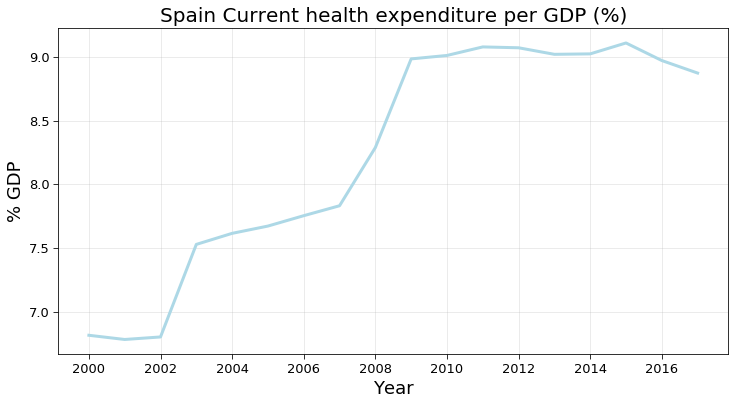

In [13]:
y = df_gdp[df_gdp['Country Name'] == 'Spain'].dropna(axis=1).iloc[:,4:].values[0][:-2]
x = df_gdp[df_gdp['Country Name'] == 'Spain'].dropna(axis=1).iloc[:,4:].columns[:-2].tolist()
print(y)
print(x)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(x, y, color='lightblue', linewidth=3)
plt.title('Spain Current health expenditure per GDP (%)', fontsize=20)
plt.tick_params(size=5,labelsize = 13)
plt.xticks([0,2,4,6,8,10,12,14,16])
plt.xlabel("Year",fontsize=18)
plt.ylabel("% GDP",fontsize=18)
plt.grid(alpha=0.3,which='both')

In [14]:
df_healthgdp = df_gdp[['Country Name','Country Code','last_hgdp_data','last_hgdp_year']].dropna()
print(df_healthgdp.shape)
df_healthgdp.head()

(234, 4)


Country Name Country Code last_hgdp_data last_hgdp_year
1           Afghanistan          AFG        11.7772           2017
2                Angola          AGO         2.7915           2017
4               Andorra          AND        10.3206           2017
5            Arab World          ARB        4.91097           2017
6  United Arab Emirates          ARE        3.33428           2017

### Oxford COVID-19 Government Response Tracker ([LINK](https://covidtracker.bsg.ox.ac.uk/)) 

BBC article using the stringency data ([LINK](https://www.bbc.com/news/world-52103747)) 

#### Stringrency data

In [16]:
df_stringency = pd.read_csv("https://oxcgrtportal.azurewebsites.net/api/CSVDownload")

d:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning:

Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.



### Eurostat ([LINK](https://ec.europa.eu/eurostat/databrowser/view/tps00168/default/table?lang=en))

#### Acute care hospital beds

In [17]:
#df_acutebeds = pd.read_csv("https://dw.euro.who.int/api/v3/export/HFA_478?lang=EN&format=csv")
df_acutebeds_source = pd.read_csv("https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/tps00168.tsv.gz",
                          sep='\t')

In [18]:
df_acutebeds_source['country_code'] = df_acutebeds_source.iloc[:,0].str.split(',',expand=True)[2]
df_acutebeds_source.columns = df_acutebeds_source.columns.str.strip(' ')

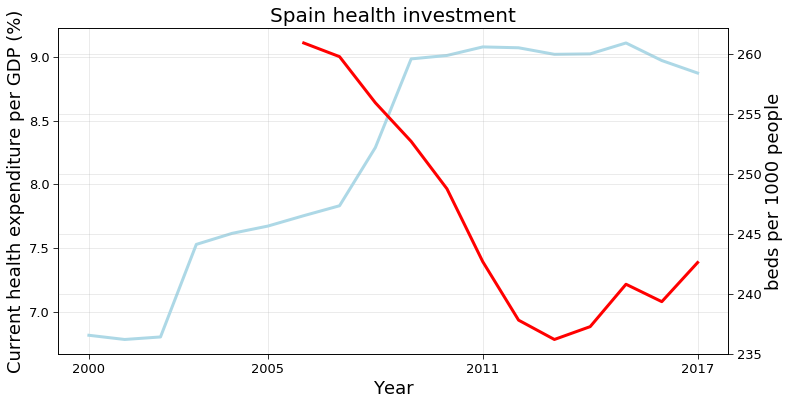

In [19]:
y = df_gdp[df_gdp['Country Name'] == 'Spain'].dropna(axis=1).iloc[:,4:].values[0][:-2]
x = np.array(df_gdp[df_gdp['Country Name'] == 'Spain'].dropna(axis=1).iloc[:,4:].columns[:-2].tolist()).astype('int32')

es = df_acutebeds_source[df_acutebeds_source['country_code'] == 'ES']
bedsy = es[es.columns[1:-1]].apply(float).values
bedsx = np.array(es[es.columns[1:-1]].columns.tolist()).astype('int32')

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(x, y, color='lightblue', linewidth=3)
plt.tick_params(size=5,labelsize = 13)
plt.xticks([0,2,4,6,8,10,12,14,16])
plt.xlabel("Year",fontsize=18)
plt.ylabel("Current health expenditure per GDP (%)",fontsize=18)
plt.grid(alpha=0.3,which='both')

ax2 = ax.twinx()
ax2.plot(bedsx, bedsy, color='red', linewidth=3)
plt.title('Spain health investment', fontsize=20)
plt.tick_params(size=5,labelsize = 13)
plt.xticks(np.linspace(2000,2017,4, dtype='int32'))
plt.xlabel("Year",fontsize=18)
plt.ylabel("beds per 1000 people",fontsize=18)
plt.grid(alpha=0.3,which='both')

In [20]:
es = df_acutebeds_source[df_acutebeds_source['country_code'] == 'ES']
es[es.columns[1:-1]]

2006     2007     2008     2009     2010     2011     2012     2013  \
10  260.90   259.76   255.92   252.70   248.75   242.68   237.81   236.20    

       2014     2015     2016    2017  
10  237.27   240.80   239.35   242.61

In [21]:
df_acutebeds = df_acutebeds_source[['country_code','2017']]

In [22]:
df_acutebeds = df_acutebeds.rename(columns={'2017':'acute_beds'})
df_acutebeds['country'] = None

In [23]:
df_acutebeds_source

unit,facility,geo\time      2006      2007      2008      2009  \
0          P_HTHAB,HBEDT_CUR,AT   637.09    637.96    629.26    622.86    
1          P_HTHAB,HBEDT_CUR,BE  569.50 b   561.43    559.38    548.74    
2          P_HTHAB,HBEDT_CUR,BG   527.24    542.72    554.38    564.84    
3          P_HTHAB,HBEDT_CUR,CH   453.96    448.30    434.79    426.64    
4          P_HTHAB,HBEDT_CUR,CY   380.31    380.12    378.45    376.22    
5          P_HTHAB,HBEDT_CUR,CZ   527.73    520.95    510.17    500.67    
6          P_HTHAB,HBEDT_CUR,DE   620.04    616.23    613.03    614.56    
7          P_HTHAB,HBEDT_CUR,DK   372.10    360.36    350.75    343.92    
8          P_HTHAB,HBEDT_CUR,EE   418.99    406.66    412.09    390.03    
9          P_HTHAB,HBEDT_CUR,EL   398.94    400.45    400.95    411.71    
10         P_HTHAB,HBEDT_CUR,ES   260.90    259.76    255.92    252.70    
11  P_HTHAB,HBEDT_CUR,EU27_2020        :         :         :         :    
12       P_HTHAB,HBEDT_CUR,EU28        :         :         :         :    
13         P_HTHAB,HBEDT_CUR,FI   364.49    357.09    349.78    341.31    
14         P_HTHAB,HBEDT_CUR,FR   362.38    358.26    351.64    349.36    
15         P_HTHAB,HBEDT_CUR,HR        :         :         :         :    
16         P_HTHAB,HBEDT_CUR,HU   594.35   447.15 b   443.13    443.75    
17         P_HTHAB,HBEDT_CUR,IE   269.46    262.15    252.72   259.18 b   
18         P_HTHAB,HBEDT_CUR,IS        :    334.76    308.75    299.22    
19         P_HTHAB,HBEDT_CUR,IT   340.93    329.45    318.45    308.46    
20         P_HTHAB,HBEDT_CUR,LI   162.69    158.81    155.05    156.68    
21         P_HTHAB,HBEDT_CUR,LT  614.15 d  617.28 d  616.00 d  615.79 d   
22         P_HTHAB,HBEDT_CUR,LU   446.86    440.01    432.21    421.47    
23         P_HTHAB,HBEDT_CUR,LV   533.37    530.56    527.67    450.12    
24         P_HTHAB,HBEDT_CUR,MK        :         :         :         :    
25         P_HTHAB,HBEDT_CUR,MT   284.97    270.95    278.71    272.02    
26         P_HTHAB,HBEDT_CUR,NL  318.49 b   317.49    309.93    306.34    
27         P_HTHAB,HBEDT_CUR,NO   450.41    435.62    412.23    399.69    
28         P_HTHAB,HBEDT_CUR,PL   465.22    461.58   441.12 b   439.47    
29         P_HTHAB,HBEDT_CUR,PT   341.44    335.93    332.69    330.25    
30         P_HTHAB,HBEDT_CUR,RO   456.10    447.69    450.47   515.91 b   
31         P_HTHAB,HBEDT_CUR,RS   464.84    446.61    441.96    444.86    
32         P_HTHAB,HBEDT_CUR,SE   261.32    259.97    255.05    252.01    
33         P_HTHAB,HBEDT_CUR,SI   454.99    446.55    452.43    437.08    
34         P_HTHAB,HBEDT_CUR,SK   554.62    559.96    554.32    546.30    
35         P_HTHAB,HBEDT_CUR,TR   249.22    251.28    255.48    259.55    
36         P_HTHAB,HBEDT_CUR,UK        :         :         :         :    

        2010      2011      2012      2013      2014      2015     2016  \
0    615.83    610.00    599.54    587.18    577.97    565.33   554.81    
1    544.69    538.33    530.11    524.39    524.37    519.16   512.07    
2    557.37    546.45    559.59    572.94    593.18    600.95   603.13    
3   390.13 b   379.48    373.26    365.51    361.95    358.46   348.65    
4    356.62    351.17    346.09    340.86    341.58    341.53   342.67    
5    479.93    459.09    445.86    421.76    418.49    416.21   414.27    
6    620.58    625.39    623.52    620.83    618.26    611.30   605.62    
7    343.55   306.70 b        :    300.40   261.82 b   245.66   252.46    
8    375.67    383.14    385.05    366.84    366.75    368.02   350.21    
9    365.64    367.23    365.64    352.24    349.69   360.40 b  357.00    
10   248.75    242.68    237.81    236.20    237.27    240.80   239.35    
11        :         :   414.16 e   409.57   406.22 e   401.25   398.66    
12        :         :         :         :         :         :        :    
13   337.82    330.23    325.06    311.95    308.58    305.35   293.62    
14   346.17    342.90    339.30  

# Preprocessing

In [24]:
for ii,row in df_acutebeds.iterrows():
    try:
        df_acutebeds.loc[ii,'country'] = pc.country_alpha2_to_country_name(row['country_code'])
    except:
        if (row['country_code'] == 'UK'):
            df_acutebeds.loc[ii,'country'] = 'United Kingdom'
        else:
            df_acutebeds.loc[ii,'country'] = None

In [25]:
population = df_population[(df_population['Time'] == 2019) &  (df_population['Variant'] == "Medium")]
population = population[['Location','PopTotal','PopDensity']]
population = population.rename(columns={"Location":"country"})
population.index = population['country']
population.head()

country     PopTotal  \
country                                                                     
Afghanistan                                      Afghanistan    38041.757   
Africa                                                Africa  1308064.176   
African Group                                  African Group  1306320.572   
African Union                                  African Union  1306903.030   
African Union: Central Africa  African Union: Central Africa   154013.705   

                               PopDensity  
country                                    
Afghanistan                        58.269  
Africa                             44.119  
African Group                      44.464  
African Union                      44.085  
African Union: Central Africa      29.192

In [26]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]
# df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

In [27]:
# Changing the conuntry names as required by pycountry_convert Lib
population.loc[population['country'] == "United States of America", "country"] = "USA"
population.loc[population['country'] == "Republic of Korea",  "country"] = 'South Korea'
population.loc[population['country'] == "China, Taiwan Province of China",  "country"] = 'Taiwan'
population.loc[population['country'] == "Congo",  "country"] = 'Republic of the Congo'
population.loc[population['country'] == "Venezuela (Bolivarian Republic of)",  "country"] = 'Venezuela'
population.loc[population['country'] == "Russian Federation",  "country"] = 'Russia'
population.loc[population['country'] == "Iran (Islamic Republic of)",  "country"] = 'Irán'
population.loc[population['country'] == "United Republic of Tanzania",  "country"] = 'Tanzania'
population.loc[population['country'] == "Bolivia (Plurinational State of)",  "country"] = 'Bolivia'

In [28]:
df_health = df_health.rename(columns={"Country Name":"country"})

In [29]:
# Changing the conuntry names as required by pycountry_convert Lib
df_health.loc[df_health['country'] == "United States", "country"] = "USA"
df_health.loc[df_health['country'] == "Korea, Rep.",  "country"] = 'South Korea'
df_health.loc[df_health['country'] == "China, Taiwan Province of China",  "country"] = 'Taiwan'
df_health.loc[df_health['country'] == "Congo, Rep.",  "country"] = 'Republic of the Congo'
df_health.loc[df_health['country'] == "Congo, Dem. Rep.",  "country"] = 'Democratic Republic of the Congo'
df_health.loc[df_health['country'] == "Venezuela, RB",  "country"] = 'Venezuela'
df_health.loc[df_health['country'] == "Russian Federation",  "country"] = 'Russia'
df_health.loc[df_health['country'] == "Iran, Islamic Rep.",  "country"] = 'Irán'
df_health.loc[df_health['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_health.loc[df_health['country'] == "Reunion", "country"] = "Réunion"

In [30]:
df_beds = df_beds.rename(columns={"Country Name":"country"})

In [31]:
# Changing the conuntry names as required by pycountry_convert Lib
df_beds.loc[df_beds['country'] == "United States", "country"] = "USA"
df_beds.loc[df_beds['country'] == "Korea, Rep.",  "country"] = 'South Korea'
df_beds.loc[df_beds['country'] == "China, Taiwan Province of China",  "country"] = 'Taiwan'
df_beds.loc[df_beds['country'] == "Congo, Rep.",  "country"] = 'Republic of the Congo'
df_beds.loc[df_beds['country'] == "Congo, Dem. Rep.",  "country"] = 'Democratic Republic of the Congo'
df_beds.loc[df_beds['country'] == "Venezuela, RB",  "country"] = 'Venezuela'
df_beds.loc[df_beds['country'] == "Russian Federation",  "country"] = 'Russia'
df_beds.loc[df_beds['country'] == "Iran, Islamic Rep.",  "country"] = 'Irán'
df_beds.loc[df_beds['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_beds.loc[df_beds['country'] == "Reunion", "country"] = "Réunion"

In [32]:
df_healthgdp = df_healthgdp.rename(columns={"Country Name":"country"})

In [33]:
# Changing the conuntry names as required by pycountry_convert Lib
df_healthgdp.loc[df_healthgdp['country'] == "United States", "country"] = "USA"
df_healthgdp.loc[df_healthgdp['country'] == "Korea, Rep.",  "country"] = 'South Korea'
df_healthgdp.loc[df_healthgdp['country'] == "China, Taiwan Province of China",  "country"] = 'Taiwan'
df_healthgdp.loc[df_healthgdp['country'] == "Congo, Rep.",  "country"] = 'Republic of the Congo'
df_healthgdp.loc[df_healthgdp['country'] == "Congo, Dem. Rep.",  "country"] = 'Democratic Republic of the Congo'
df_healthgdp.loc[df_healthgdp['country'] == "Venezuela, RB",  "country"] = 'Venezuela'
df_healthgdp.loc[df_healthgdp['country'] == "Russian Federation",  "country"] = 'Russia'
df_healthgdp.loc[df_healthgdp['country'] == "Iran, Islamic Rep.",  "country"] = 'Irán'
df_healthgdp.loc[df_healthgdp['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_healthgdp.loc[df_healthgdp['country'] == "Reunion", "country"] = "Réunion"

In [34]:
#stringency
df_stringency[df_stringency['CountryName'].str.contains('South')].CountryName.unique()

array(['South Korea', 'South Sudan', 'South Africa'], dtype=object)

In [35]:
#stringency
df_stringency.loc[df_stringency['CountryName'] == "United States", "CountryName"] = "USA"

In [85]:
#df_confirmed.loc[df_confirmed['country'].str.contains("Taji")] 

Empty DataFrame
Columns: [state, country, continent, Lat, Long, 1/22/20, 1/23/20, 1/24/20, 1/25/20, 1/26/20, 1/27/20, 1/28/20, 1/29/20, 1/30/20, 1/31/20, 2/1/20, 2/2/20, 2/3/20, 2/4/20, 2/5/20, 2/6/20, 2/7/20, 2/8/20, 2/9/20, 2/10/20, 2/11/20, 2/12/20, 2/13/20, 2/14/20, 2/15/20, 2/16/20, 2/17/20, 2/18/20, 2/19/20, 2/20/20, 2/21/20, 2/22/20, 2/23/20, 2/24/20, 2/25/20, 2/26/20, 2/27/20, 2/28/20, 2/29/20, 3/1/20, 3/2/20, 3/3/20, 3/4/20, 3/5/20, 3/6/20, 3/7/20, 3/8/20, 3/9/20, 3/10/20, 3/11/20, 3/12/20, 3/13/20, 3/14/20, 3/15/20, 3/16/20, 3/17/20, 3/18/20, 3/19/20, 3/20/20, 3/21/20, 3/22/20, 3/23/20, 3/24/20, 3/25/20, 3/26/20, 3/27/20, 3/28/20, 3/29/20, 3/30/20, 3/31/20, 4/1/20, 4/2/20, 4/3/20, 4/4/20, 4/5/20, 4/6/20, 4/7/20, 4/8/20, 4/9/20, 4/10/20, 4/11/20, 4/12/20, 4/13/20, 4/14/20, 4/15/20, 4/16/20, 4/17/20, 4/18/20, 4/19/20, 4/20/20, 4/21/20, 4/22/20, 4/23/20, 4/24/20, 4/25/20, ...]
Index: []

[0 rows x 104 columns]

In [36]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
# df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"


df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"
# df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"
# df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"
# df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"
# df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"
# df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

#Collecting Continent Information
df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])
# df_recovered.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]] )   

In [37]:
df_table = df_table[df_table["continent"] != "Others"]

In [38]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

In [58]:
df_stringency

CountryName CountryCode      Date  C1_School closing  \
0                             Aruba         ABW  20200101                0.0   
1                       Afghanistan         AFG  20200101                0.0   
2                            Angola         AGO  20200101                0.0   
3                           Albania         ALB  20200101                0.0   
4                           Andorra         AND  20200101                0.0   
5              United Arab Emirates         ARE  20200101                0.0   
6                         Argentina         ARG  20200101                0.0   
7                         Australia         AUS  20200101                0.0   
8                           Austria         AUT  20200101                0.0   
9                        Azerbaijan         AZE  20200101                0.0   
10                          Burundi         BDI  20200101                0.0   
11                          Belgium         BEL  20200101                0.0   
12                     Burkina Faso         BFA  20200101                0.0   
13                       Bangladesh         BGD  20200101                0.0   
14                         Bulgaria         BGR  20200101                0.0   
15                          Bahrain         BHR  20200101                0.0   
16           Bosnia and Herzegovina         BIH  20200101                0.0   
17                           Belize         BLZ  20200101                0.0   
18                          Bermuda         BMU  20200101                0.0   
19                          Bolivia         BOL  20200101                0.0   
20                           Brazil         BRA  20200101                0.0   
21                         Barbados         BRB  20200101                0.0   
22                           Brunei         BRN  20200101                0.0   
23                         Botswana         BWA  20200101                0.0   
24                           Canada         CAN  20200101                0.0   
25                      Switzerland         CHE  20200101                0.0   
26                            Chile         CHL  20200101                0.0   
27                            China         CHN  20200101                0.0   
28                         Cameroon         CMR  20200101                0.0   
29     Democratic Republic of Congo         COD  20200101                0.0   
...                             ...         ...       ...                ...   
18238                         Sudan         SDN  20200430                NaN   
18239                     Singapore         SGP  20200430                NaN   
18240                  Sierra Leone         SLE  20200430                NaN   
18241                   El Salvador         SLV  20200430                3.0   
18242                    San Marino         SMR  20200430                3.0   
18243                        Serbia         SRB  20200430                NaN   
18244                   South Sudan         SSD  20200430                NaN   
18245               Slovak Republic         SVK  20200430                NaN   
18246                      Slovenia         SVN  20200430                3.0   
18247                        Sweden         SWE  20200430                NaN   
18248                      Eswatini         SWZ  20200430                NaN   
18249                    Seychelles         SYC  20200430                3.0   
18250                         Syria         SYR  20200430                NaN   
18251                          Chad         TCD  20200430                NaN   
18252                      Thailand         THA  20200430                NaN   
18253           Trinidad and Tobago         TTO  20200430                NaN   
18254                       Tunisia         TUN  20200430                NaN   
18255                        Turkey         TUR  20200430                NaN   
18256                   

# Functions

In [86]:
#function to calculate the date when schools close (S1)

from datetime import datetime

def dateS1(country, df):
    date = 20200101
    s = df[df['CountryName'] == country]
    try:
        date = s[s['C1_School closing'] > 0].iloc[0,2]
    except IndexError as error:
        print(error)
        return  None
    return datetime.strptime(str(date), "%Y%m%d") 

#fuction to find the date first case
def dateFirst(country, df, th=0):
    date = "1/22/20"
    try:
        c = df.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df.columns[-1], ascending= False)
        c = c.loc[country,:]
    except KeyError as error:
        print(error)
        return None
    try:
        date = c[c > th].index[0]
    except IndexError as error:
            print(error)
            return None
    return datetime.strptime(date, "%m/%d/%y")


In [40]:
#ejemplo
#primer_remedio = dateS1("Sweden",df_stringency)
#primer_caso = dateFirst("Spain",df_confirmed)

#print(primer_caso)
#print(primer_remedio)

#print((primer_remedio - primer_caso).days)

#convert dates
#from datetime import datetime
#date_object = datetime.strptime(primer_caso, "%m/%d/%y")
#print("date object =", date_object)
#date_object2 = datetime.strptime(primer_remedio, "%Y%m%d")
#print("date object2 =", date_object2)

In [41]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    plt.minorticks_on()
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = "output/"#+"output/"

# General Analysis

In [42]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

### Top 10 countries (Confirmed Cases and Deaths)

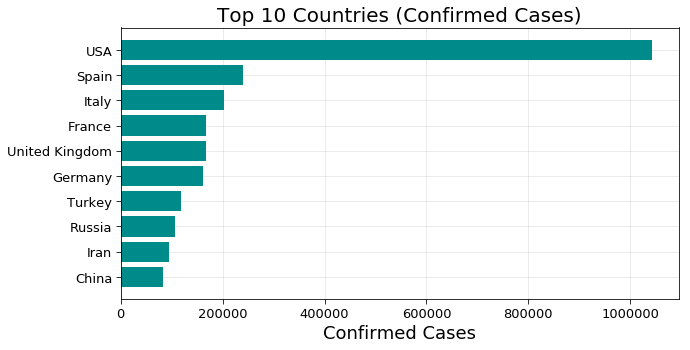

In [43]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-10:],df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig(out+'Top 10 Countries (Confirmed Cases).png')

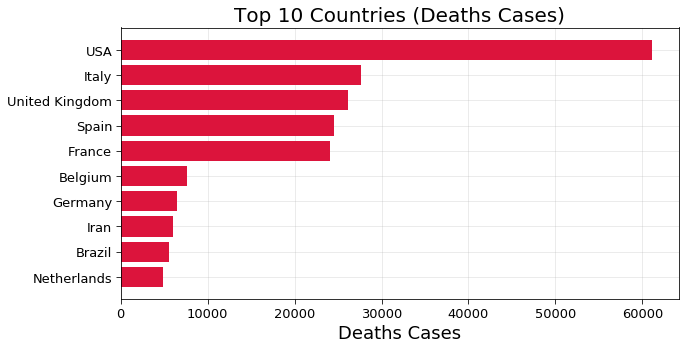

In [44]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:],df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 Countries (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Deaths Cases).png')

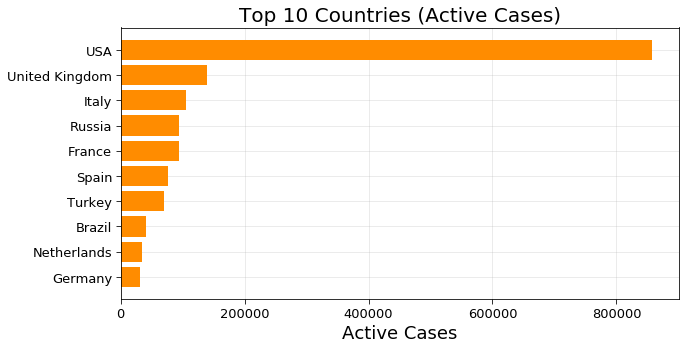

In [45]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Active')["Active"].index[-10:],df_countries_cases.sort_values('Active')["Active"].values[-10:],color="darkorange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Active Cases",fontsize=18)
plt.title("Top 10 Countries (Active Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Active Cases).png')

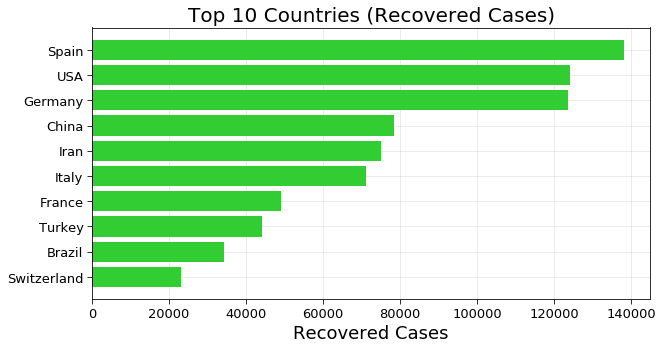

In [46]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Recovered')["Recovered"].index[-10:],df_countries_cases.sort_values('Recovered')["Recovered"].values[-10:],color="limegreen")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Recovered Cases",fontsize=18)
plt.title("Top 10 Countries (Recovered Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Recovered Cases).png')

## Maps deaths

In [47]:
temp_df = pd.DataFrame(df_countries_cases['Deaths'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df.iloc[:,-1]+1), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Deaths"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Deaths Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Deaths (Log Scale)",colorscale="Reds")
# fig.to_image("Global Heat Map deaths.png")
vec = [0,0.5,1,1.5,2,2.5,3,3.5,4]

fig.update_layout(coloraxis_colorbar=dict(
    title="Deaths Heat Map (Log Scale)",
    tickvals=vec,
    ticktext=np.power(10,vec).astype(int)
))

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

### Deaths map by population

In [48]:
temp_df = pd.DataFrame(df_countries_cases['Deaths'])
temp_df = temp_df.reset_index()
ttter = temp_df.copy()
ttter.index = ttter['country']
ttter = ttter.drop(columns =['country'])
perro = pd.concat([ttter, population.drop(columns =['country'])], axis=1, join='inner')
perro = perro.reset_index()
perro['deaths100k'] = perro['Deaths']/(perro['PopTotal']*1000)*100000

fig = px.choropleth(perro, locations="country",
                    color=np.log10(perro.iloc[:,-1]+1), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["deaths100k"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Deaths per 100k population")
fig.update_coloraxes(colorbar_title="Deaths per 100k (Log Scale)",colorscale="Purples")
# fig.to_image("Global Heat Map deaths.png")
vec = [0,0.5,1,1.5,2]

fig.update_layout(coloraxis_colorbar=dict(
    title="Deaths per 100k (Log Scale)",
    tickvals=vec,
    ticktext=np.power(10,vec).astype(int)
))

#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html(out+"Deathsper100k.html", include_plotlyjs='cdn')
fig.show()

## Deaths per 100k population

In [49]:
temp_df = pd.DataFrame(df_countries_cases['Deaths'])
temp_df = temp_df.reset_index()
ttter = temp_df.copy()
ttter.index = ttter['country']
ttter = ttter.drop(columns =['country'])
perro = pd.concat([ttter, population.drop(columns =['country'])], axis=1, join='inner')
perro = perro.reset_index()
perro['deaths100k'] = perro['Deaths']/(perro['PopTotal']*1000)*100000
perro['mortality'] = perro['Deaths']/(perro['PopTotal']*1000)*100

In [50]:
perro[perro['PopTotal'] > 100].sort_values('mortality', ascending=False).head(10)

country  Deaths    PopTotal  PopDensity  deaths100k  mortality
32          Belgium    7594   11539.326     381.087   65.809736   0.065810
152           Spain   24543   46736.782      93.698   52.513243   0.052513
10            Italy   27682   60550.092     205.855   45.717519   0.045718
16   United Kingdom   26166   67530.161     279.131   38.747131   0.038747
6            France   24121   65129.731     118.946   37.035313   0.037035
11      Netherlands    4811   17097.123     507.032   28.139237   0.028139
14           Sweden    2586   10036.391      24.459   25.766234   0.025766
9           Ireland    1190    4882.498      70.874   24.372770   0.024373
15      Switzerland    1737    8591.361     217.415   20.217984   0.020218
17              USA   61123  329064.917      35.974   18.574754   0.018575

La columna PopTotal esta en 1 miles

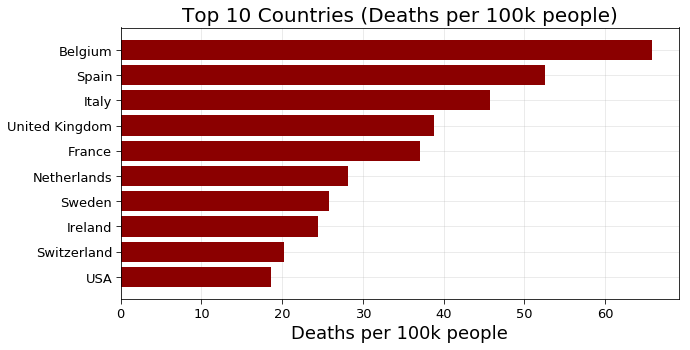

In [51]:
#paises mas de un millon
paises_mas1M = perro[perro['PopTotal'] > 1000]

f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(paises_mas1M.sort_values('deaths100k')["country"].values[-10:],paises_mas1M.sort_values('deaths100k')["deaths100k"].values[-10:],color="darkred")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths per 100k people",fontsize=18)
plt.title("Top 10 Countries (Deaths per 100k people)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Deaths per 100k people).png')

d:\program files\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

d:\program files\python37\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and po

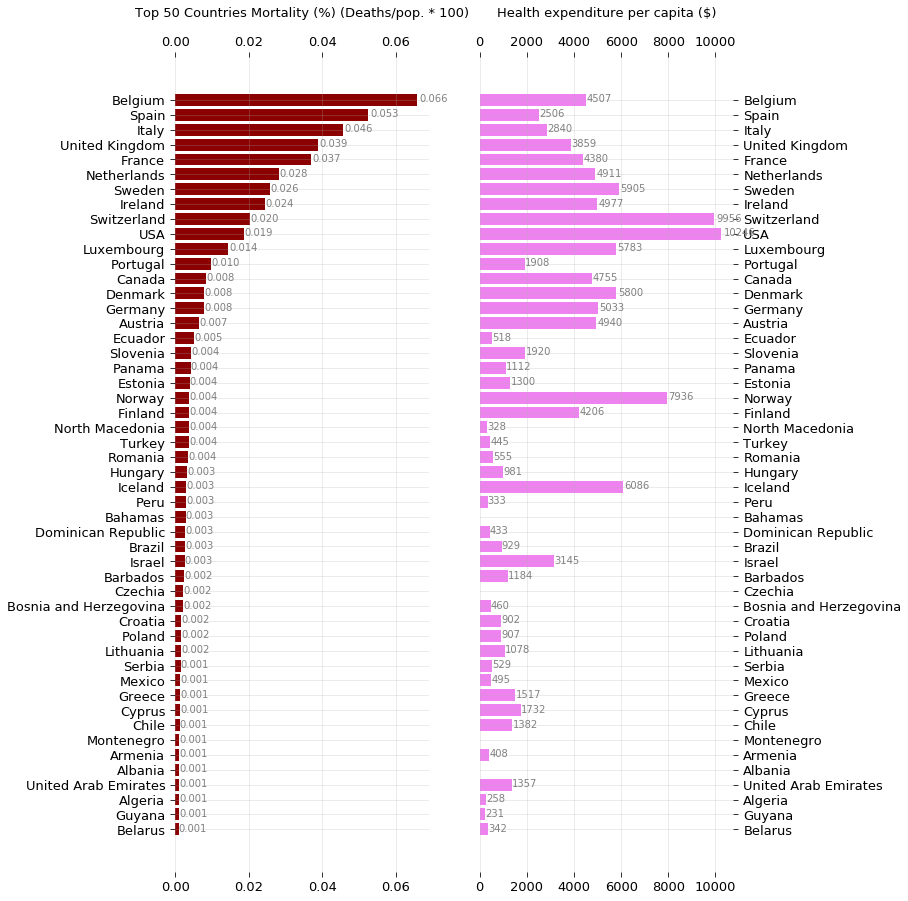

In [52]:
top = 50
chucho = perro[perro['PopTotal'] > 100].sort_values('mortality')
chucho.index = chucho.country

padtitle = 40

f = plt.figure(figsize=(10,15))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)


#f.tight_layout(pad=0.05)

countries = chucho["mortality"].index[-top:].tolist()

#ax1.axes(axisbelow=True)
ax1.barh(chucho["mortality"].index[-top:],chucho["mortality"].values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_title("Top {} Countries Mortality (%) (Deaths/pop. * 100)".format(top),fontsize=13, pad=padtitle)   
ax1.grid(alpha=0.3,which='both')
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['top'].set_linewidth(0)
ax1.spines['right'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)
for i in ax1.patches:
    ax1.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.3f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
#plt.savefig(out+'Top 10 Countries (Mortality).png')
ax1.xaxis.set_tick_params(labeltop='on',top=True)
ax1.tick_params(axis="y", pad=5)

health = df_health.copy()
health.index = health.country

pepito = health.loc[chucho["mortality"].index[-top:].tolist(),:]

#plt.axes(axisbelow=True)
ax2.barh(pepito['2017'].index[-top:],pepito['2017'].values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
ax2.set_title("Health expenditure per capita ($)",fontsize=13, pad=padtitle)             
ax2.grid(alpha=0.3,which='both')
ax2.yaxis.tick_right()
ax2.grid(alpha=0.3,which='both')
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
for i in ax2.patches:
    ax2.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')

ax2.xaxis.set_tick_params(labeltop='on',top=True)
ax2.tick_params(axis="y", pad=5)

plt.savefig(out+'mortality and health expenditure all.png')

In [53]:
pepito.sort_values(by='2017', ascending=False)

country Country Code          2017
country                                                                  
USA                                        USA          USA  10246.138672
Switzerland                        Switzerland          CHE   9956.259766
Norway                                  Norway          NOR   7936.375000
Iceland                                Iceland          ISL   6086.311523
Sweden                                  Sweden          SWE   5904.583984
Denmark                                Denmark          DNK   5800.151367
Luxembourg                          Luxembourg          LUX   5782.628418
Germany                                Germany          DEU   5033.452148
Ireland                                Ireland          IRL   4976.862305
Austria                                Austria          AUT   4939.875488
Netherlands                        Netherlands          NLD   4911.440430
Canada                                  Canada          CAN   4754.947754
Belgium                                Belgium          BEL   4507.356445
France                                  France          FRA   4379.727051
Finland                                Finland          FIN   4205.742676
United Kingdom                  United Kingdom          GBR   3858.674316
Israel                                  Israel          ISR   3144.626221
Italy                                    Italy          ITA   2840.130615
Spain                                    Spain          ESP   2506.464844
Slovenia                              Slovenia          SVN   1920.281860
Portugal                              Portugal          PRT   1908.033936
Cyprus                                  Cyprus          CYP   1731.694458
Greece                                  Greece          GRC   1516.587769
Chile                                    Chile          CHL   1381.986206
United Arab Emirates      United Arab Emirates          ARE   1357.017456
Estonia                                Estonia          EST   1300.481689
Barbados                              Barbados          BRB   1183.836182
Panama                                  Panama          PAN   1112.303223
Lithuania                            Lithuania          LTU   1078.179199
Hungary                                Hungary          HUN    981.423035
Brazil                                  Brazil          BRA    928.799316
Poland                                  Poland          POL    906.820129
Croatia                                Croatia          HRV    902.139648
Romania                                Romania          ROU    555.104736
Serbia                                  Serbia          SRB    528.545166
Ecuador                                Ecuador          ECU    518.029602
Mexico                                  Mexico          MEX    494.677643
Bosnia and Herzegovina  Bosnia and Herzegovina          BIH    460.473328
Turkey                                  Turkey          TUR    444.653687
Dominican Republic          Dominican Republic          DOM    433.208588
Armenia                                Armenia          ARM    407.635864
Belarus                                Belarus          BLR    342.499908
Peru                                      Peru          PER    332.570923
North Macedonia                North Macedonia          MKD    328.419800
Algeria                                Algeria          DZA    258.494293
Guyana                                  Guyana          GUY    230.527283
Albania                                    NaN          NaN           NaN
Montenegro                                 NaN          NaN           NaN
Czechia                                    NaN          NaN           NaN
Bahamas                                    NaN          NaN           NaN

In [54]:
df_countries_cases.loc[countries,:]

Confirmed  Deaths  Recovered  Active  Incident_Rate  \
country                                                                       
Belarus                     14027      89       2386   11552     148.444528   
Guyana                         78       8         18      52       9.916611   
Algeria                      3848     444       1702    1702       8.775162   
United Arab Emirates        12481     105       2429    9947     126.193076   
Albania                       773      31        470     272      26.860796   
Armenia                      2066      32        929    1105      69.721122   
Montenegro                    322       7        206     109      51.268824   
Chile                       16023     227       8580    7216      83.818920   
Cyprus                        843      15        148     680      69.821702   
Greece                       2576     139        577    1860      24.714441   
Mexico                      17799    1732      11423    4644      13.804871   
Serbia                       6630     125        870    5635      75.880957   
Lithuania                    1385      45        589     751      50.876266   
Poland                      12781     628       3236    8917      33.770532   
Croatia                      2076      69       1348     659      50.569171   
Bosnia and Herzegovina       1757      69        727     961      53.553766   
Czechia                      7581     227       3120    4234      70.791043   
Barbados                       80       7         39      34      27.838578   
Israel                      15870     219       8412    7239     183.350758   
Brazil                      79685    5513      34132   40040      37.488343   
Dominican Republic           6652     293       1228    5131      61.320602   
Bahamas                        80      11         25      44      20.343397   
Peru                        33931     943      10037   22951     102.909009   
Iceland                      1797      10       1656     131     526.593407   
Hungary                      2775     312        581    1882      28.725667   
Romania                     12240     695       4017    7528      63.625129   
Turkey                     117589    3081      44040   70468     139.424118   
North Macedonia              1465      77        738     650      70.318425   
Finland                      4995     211       3000    1784      90.150771   
Norway                       7710     207         32    7471     142.218333   
Estonia                      1689      52        249    1388     127.323810   
Panama                       6378     178        527    5673     147.817913   
Slovenia                     1429      91        233    1105      68.737217   
Ecuador                     24675     883       1557   22235     139.856692   
Austria                     15452     584      12907    1961     171.566886   
Germany                    161845    6470     123500   31875     193.169467   
Denmark                      9356     452       6741    2163     161.527488   
Canada                      52865    3155      20327   29383     139.648711   
Portugal                    25045     989       1519   22537     245.618512   
Luxembourg                   3769      89       3134     546     602.099761   
USA                       1042874   61123     124064  857687     316.534363   
Switzerland                 29586    1737      23100    4749     341.852176   
Ireland                     20253    1190      13386    5677     410.162753   
Sweden                      21092    2586       1005   17501     208.846778   
Netherlands                 39512    4811        119   34582     230.594064   
France                     166628   24121      49132   93375     255.276597   
United Kingdom             166441   26166        857  139418     245.177194   
Italy                      203591   27682      71252  104657     336.726505   
Spain                      239639   24543     137984   77112     512.54435

### Analysis comparatory against health investment per capita and reaction time

In [57]:
df_stringency

CountryName CountryCode      Date  C1_School closing  \
0                             Aruba         ABW  20200101                0.0   
1                       Afghanistan         AFG  20200101                0.0   
2                            Angola         AGO  20200101                0.0   
3                           Albania         ALB  20200101                0.0   
4                           Andorra         AND  20200101                0.0   
5              United Arab Emirates         ARE  20200101                0.0   
6                         Argentina         ARG  20200101                0.0   
7                         Australia         AUS  20200101                0.0   
8                           Austria         AUT  20200101                0.0   
9                        Azerbaijan         AZE  20200101                0.0   
10                          Burundi         BDI  20200101                0.0   
11                          Belgium         BEL  20200101                0.0   
12                     Burkina Faso         BFA  20200101                0.0   
13                       Bangladesh         BGD  20200101                0.0   
14                         Bulgaria         BGR  20200101                0.0   
15                          Bahrain         BHR  20200101                0.0   
16           Bosnia and Herzegovina         BIH  20200101                0.0   
17                           Belize         BLZ  20200101                0.0   
18                          Bermuda         BMU  20200101                0.0   
19                          Bolivia         BOL  20200101                0.0   
20                           Brazil         BRA  20200101                0.0   
21                         Barbados         BRB  20200101                0.0   
22                           Brunei         BRN  20200101                0.0   
23                         Botswana         BWA  20200101                0.0   
24                           Canada         CAN  20200101                0.0   
25                      Switzerland         CHE  20200101                0.0   
26                            Chile         CHL  20200101                0.0   
27                            China         CHN  20200101                0.0   
28                         Cameroon         CMR  20200101                0.0   
29     Democratic Republic of Congo         COD  20200101                0.0   
...                             ...         ...       ...                ...   
18238                         Sudan         SDN  20200430                NaN   
18239                     Singapore         SGP  20200430                NaN   
18240                  Sierra Leone         SLE  20200430                NaN   
18241                   El Salvador         SLV  20200430                3.0   
18242                    San Marino         SMR  20200430                3.0   
18243                        Serbia         SRB  20200430                NaN   
18244                   South Sudan         SSD  20200430                NaN   
18245               Slovak Republic         SVK  20200430                NaN   
18246                      Slovenia         SVN  20200430                3.0   
18247                        Sweden         SWE  20200430                NaN   
18248                      Eswatini         SWZ  20200430                NaN   
18249                    Seychelles         SYC  20200430                3.0   
18250                         Syria         SYR  20200430                NaN   
18251                          Chad         TCD  20200430                NaN   
18252                      Thailand         THA  20200430                NaN   
18253           Trinidad and Tobago         TTO  20200430                NaN   
18254                       Tunisia         TUN  20200430                NaN   
18255                        Turkey         TUR  20200430                NaN   
18256                   

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


d:\program files\python37\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



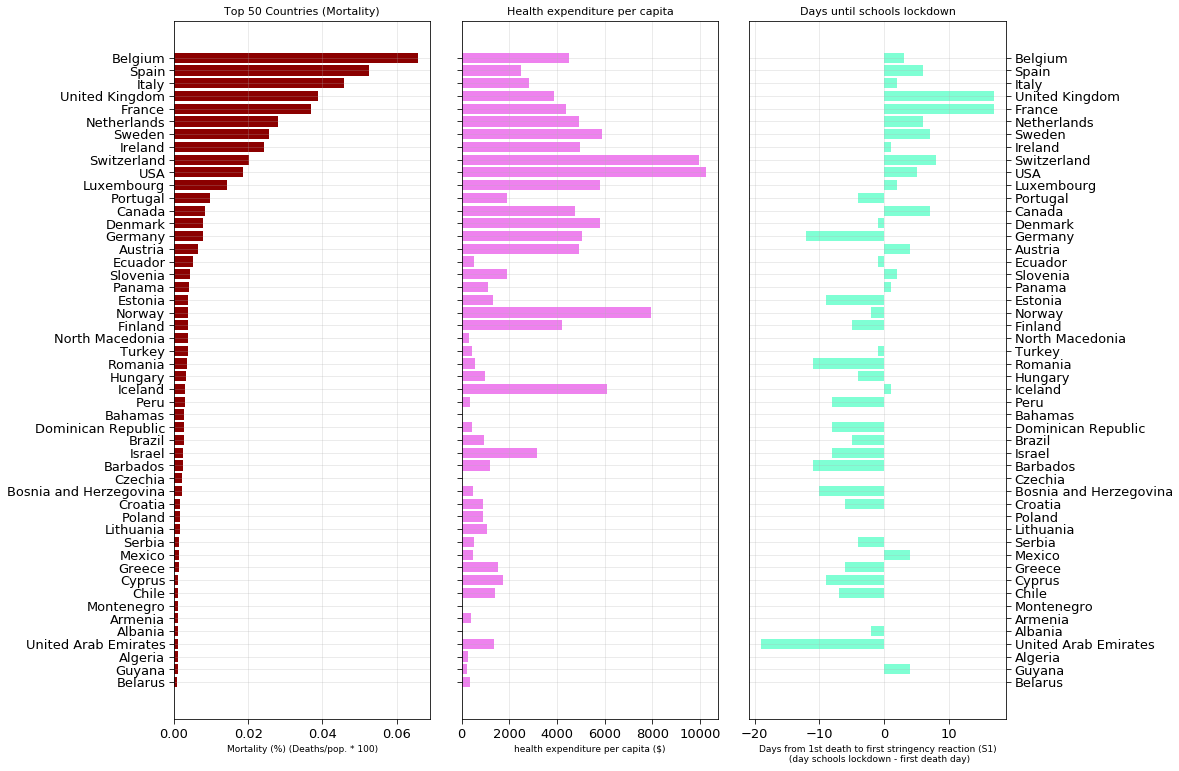

In [60]:
top = 50
indice = chucho["mortality"].index[-top:]
dias_primer_caso = [dateFirst(country,df_deaths,0) for country in indice.tolist()]
dias_primera_accion = [dateS1(country,df_stringency) for country in indice.tolist()]

df_actuacion = pd.DataFrame({'country':indice.tolist(),
              'first_case':dias_primer_caso,
              'first_measure':dias_primera_accion})

df_actuacion['dias_en_actuar'] = df_actuacion['first_measure'] - df_actuacion['first_case']
#df_actuacion = df_actuacion.replace({pd.np.nan: None})

df_actuacion['dias_en_actuar'] = df_actuacion['dias_en_actuar'].apply(lambda x: x.days)


f = plt.figure(figsize=(12,10))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

f.tight_layout(pad=0.05)



#ax1.axes(axisbelow=True)
ax1.barh(chucho["mortality"].index[-top:],chucho["mortality"].values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_xlabel("Mortality (%) (Deaths/pop. * 100)",fontsize=9)
ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Mortality).png')

health = df_health.copy()
health.index = health.country

pepito = health.loc[chucho["mortality"].index[-top:].tolist(),:]

#plt.axes(axisbelow=True)
ax2.barh(pepito['2017'].index[-top:],pepito['2017'].values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
ax2.set_xlabel("health expenditure per capita ($)",fontsize=9)
ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')

#plt.axes(axisbelow=True)
ax3.barh(df_actuacion.country,df_actuacion.fillna(0).dias_en_actuar,color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
ax3.set_xlabel("Days from 1st death to first stringency reaction (S1)\n (day schools lockdown - first death day)",fontsize=9)
ax3.set_title("Days until schools lockdown",fontsize=11)
ax3.yaxis.tick_right()
ax3.grid(alpha=0.3,which='both')

plt.savefig('mortality and health and reaction.png')

### Analysis comparatory against beds per 100k and reaction time

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


d:\program files\python37\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



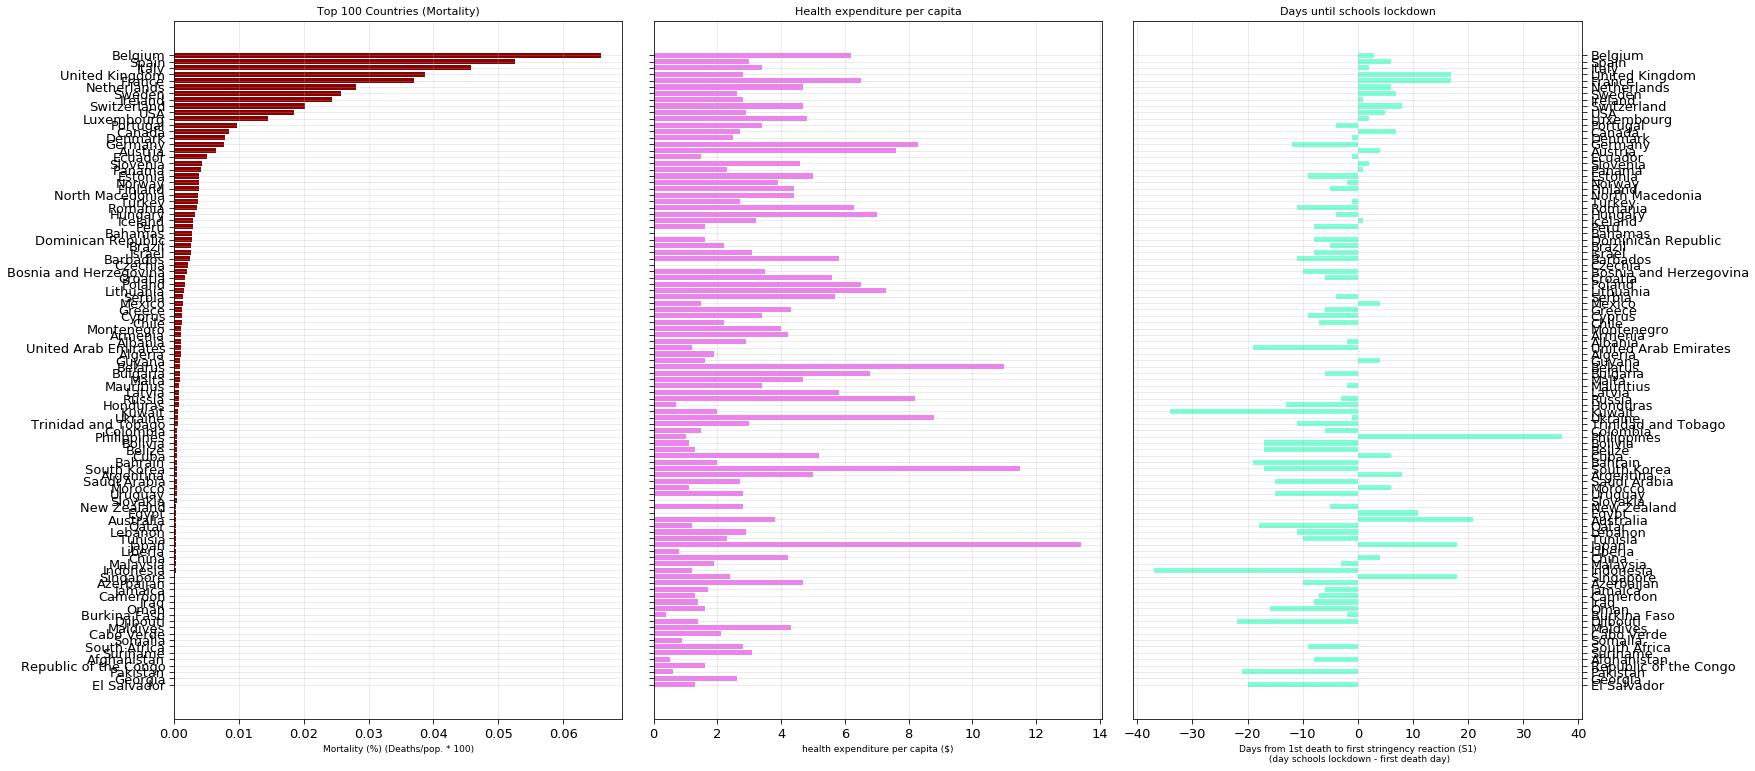

In [61]:
top = 100
indice = chucho["mortality"].index[-top:]
dias_primer_caso = [dateFirst(country,df_deaths,0) for country in indice.tolist()]
dias_primera_accion = [dateS1(country,df_stringency) for country in indice.tolist()]

df_actuacion = pd.DataFrame({'country':indice.tolist(),
              'first_case':dias_primer_caso,
              'first_measure':dias_primera_accion})

df_actuacion['dias_en_actuar'] = df_actuacion['first_measure'] - df_actuacion['first_case']
#df_actuacion = df_actuacion.replace({pd.np.nan: None})

df_actuacion['dias_en_actuar'] = df_actuacion['dias_en_actuar'].apply(lambda x: x.days)


f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

f.tight_layout(pad=0.05)



#ax1.axes(axisbelow=True)
ax1.barh(chucho["mortality"].index[-top:],chucho["mortality"].values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_xlabel("Mortality (%) (Deaths/pop. * 100)",fontsize=9)
ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Mortality).png')

beds = df_beds.copy()
beds.index = beds.country

datos_camas = beds.loc[chucho["mortality"].index[-top:].tolist(),:]

#plt.axes(axisbelow=True)
ax2.barh(datos_camas['last_data'].index[-top:],datos_camas['last_data'].values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
ax2.set_xlabel("health expenditure per capita ($)",fontsize=9)
ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')

#plt.axes(axisbelow=True)
ax3.barh(df_actuacion.country,df_actuacion.fillna(0).dias_en_actuar,color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
ax3.set_xlabel("Days from 1st death to first stringency reaction (S1)\n (day schools lockdown - first death day)",fontsize=9)
ax3.set_title("Days until schools lockdown",fontsize=11)
ax3.yaxis.tick_right()
ax3.grid(alpha=0.3,which='both')

plt.savefig('mortality and health and reaction.png')

## Deaths comparison only Europe

In [62]:
muertes = pd.DataFrame(df_countries_cases['Deaths']).reset_index().copy()
muertes.index = muertes['country']
muertes = muertes.drop(columns =['country'])
compare_muertes = pd.concat([muertes, population.drop(columns =['country'])], axis=1, join='inner')
compare_muertes = compare_muertes.reset_index()
compare_muertes['deaths100k'] = compare_muertes['Deaths']/(compare_muertes['PopTotal']*1000)*100000
compare_muertes['mortality'] = compare_muertes['Deaths']/(compare_muertes['PopTotal']*1000)*100

In [63]:
inversion_salud = df_health.copy()
inversion_salud.index = health.country
inversion_salud = inversion_salud.rename(columns={'2017':'health_capita'})
inversion_salud = inversion_salud.drop(columns=['country'])


In [64]:
compare_muertes = inversion_salud.merge(compare_muertes, left_on='country', right_on='country')

In [65]:
camas_mil = df_beds.copy()
camas_mil = camas_mil.drop(columns=['Country Code'])
camas_mil = camas_mil.rename(columns={'last_data':'beds_last_data', 'last_year':'beds_last_year'})

In [66]:
compare_muertes = camas_mil.merge(compare_muertes, left_on='country', right_on='country')

In [67]:
compare_muertes = df_healthgdp[['country','last_hgdp_data','last_hgdp_year']].merge(compare_muertes, left_on='country', right_on='country')

In [87]:
indice = chucho["mortality"].index
dias_primer_muerte = [dateFirst(country,df_deaths,0) for country in indice.tolist()]
dias_primer_50casos = [dateFirst(country,df_confirmed,49) for country in indice.tolist()]
dias_primera_accion = [dateS1(country,df_stringency) for country in indice.tolist()]
df_actuacion = pd.DataFrame({'country':indice.tolist(),
              'first_death':dias_primer_muerte,
              '50first_confirmed':dias_primer_50casos,
              'first_measure':dias_primera_accion})
df_actuacion['dias_en_actuar_d'] = df_actuacion['first_measure'] - df_actuacion['first_death']
#df_actuacion = df_actuacion.replace({pd.np.nan: None})
df_actuacion['dias_en_actuar_d'] = df_actuacion['dias_en_actuar_d'].apply(lambda x: x.days)

df_actuacion['dias_en_actuar_50c'] = df_actuacion['first_measure'] - df_actuacion['50first_confirmed']
df_actuacion['dias_en_actuar_50c'] = df_actuacion['dias_en_actuar_50c'].apply(lambda x: x.days)

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
'Tajikistan'
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds fo

In [88]:
compare_muertes = df_actuacion.merge(compare_muertes, left_on='country', right_on='country')

In [89]:
compare_muertes.head()

country first_death 50first_confirmed first_measure  \
0            Rwanda         NaT        2020-03-26    2020-03-16   
1            Bhutan         NaT               NaT           NaT   
2           Eritrea         NaT               NaT           NaT   
3  Papua New Guinea         NaT               NaT    2020-03-23   
4              Fiji         NaT               NaT           NaT   

   dias_en_actuar_d  dias_en_actuar_50c last_hgdp_data last_hgdp_year  \
0               NaN               -10.0         6.5716           2017   
1               NaN                 NaN        3.18696           2017   
2               NaN                 NaN        2.87002           2017   
3               NaN                 NaN        2.46928           2017   
4               NaN                 NaN        3.50074           2017   

  beds_last_data beds_last_year Country Code  health_capita  Deaths  \
0            1.6           2007          RWA      49.204456       0   
1            1.7           2012          BTN      96.799301       0   
2            0.7           2011          ERI      32.911999       0   
3         4.0242           1990          PNG      61.457840       0   
4            2.3           2011          FJI     188.414322       0   

    PopTotal  PopDensity  deaths100k  mortality  
0  12626.938     511.834         0.0        0.0  
1    763.094      20.020         0.0        0.0  
2   3497.117      34.625         0.0        0.0  
3   8776.119      19.379         0.0        0.0  
4    889.955      48.711         0.0        0.0

#### Europe

In [90]:
paises = np.asarray(compare_muertes["country"])
compare_muertes.insert(2,"continent", [continents[country_to_continent_code(country)] for country in paises[:]])

In [91]:
compare_muertes_europe = compare_muertes[compare_muertes['continent'] == 'Europe']
compare_muertes_europe = df_acutebeds[['country','acute_beds']].merge(compare_muertes_europe, on='country')
print(compare_muertes_europe.shape)
compare_muertes_europe = compare_muertes_europe.sort_values(by='mortality')
compare_muertes_europe.head(5)

(29, 19)


country  acute_beds first_death continent 50first_confirmed  \
17     Latvia      329.88  2020-04-03    Europe        2020-03-18   
19      Malta      317.52  2020-04-08    Europe        2020-03-19   
2    Bulgaria      616.82  2020-03-11    Europe        2020-03-15   
25     Serbia      464.12  2020-03-20    Europe        2020-03-16   
15  Lithuania      547.20  2020-03-21    Europe        2020-03-21   

   first_measure  dias_en_actuar_d  dias_en_actuar_50c last_hgdp_data  \
17           NaT               NaN                 NaN        5.95566   
19           NaT               NaN                 NaN          9.341   
2     2020-03-05              -6.0               -10.0         8.0956   
25    2020-03-16              -4.0                 0.0        8.43396   
15           NaT               NaN                 NaN        6.45756   

   last_hgdp_year beds_last_data beds_last_year Country Code  health_capita  \
17           2017            5.8           2013          LVA     930.352356   
19           2017            4.7           2014          MLT    2585.563965   
2            2017            6.8           2013          BGR     663.715088   
25           2017            5.7           2012          SRB     528.545166   
15           2017            7.3           2013          LTU    1078.179199   

    Deaths  PopTotal  PopDensity  deaths100k  mortality  
17      15  1906.740      30.655    0.786683   0.000787  
19       4   440.377    1376.178    0.908313   0.000908  
2       65  7000.117      64.482    0.928556   0.000929  
25     125  8772.228     100.300    1.424952   0.001425  
15      45  2759.631      44.032    1.630653   0.001631

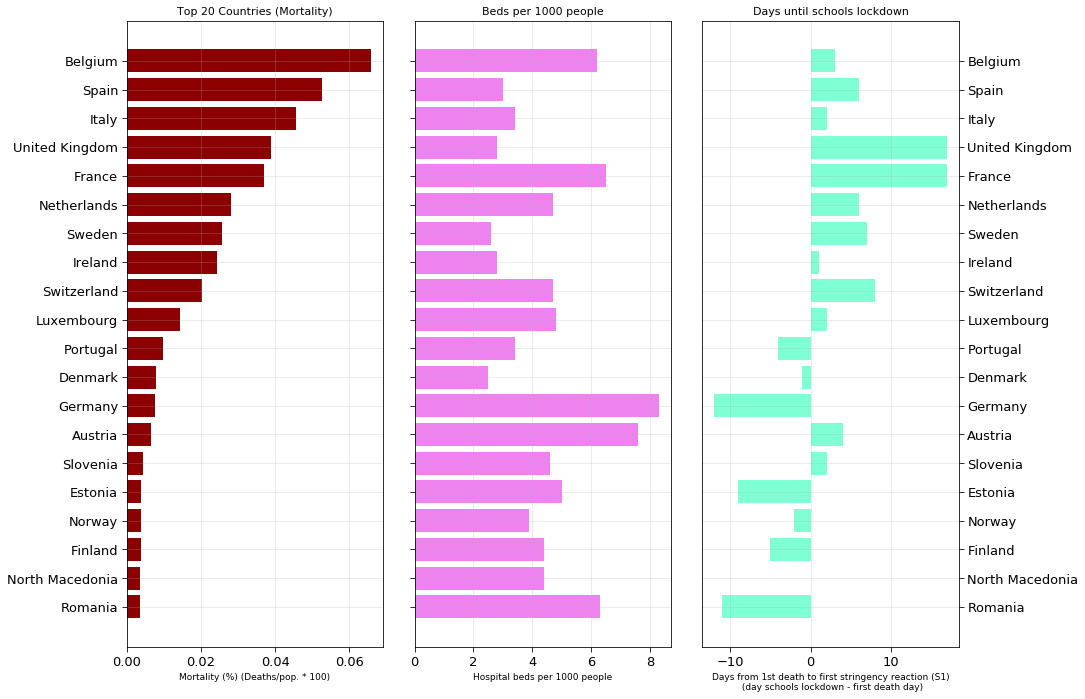

In [92]:
top = 20
f = plt.figure(figsize=(12,9))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

f.tight_layout(pad=0.05)

#ax1.axes(axisbelow=True)
ax1.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.mortality.values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_xlabel("Mortality (%) (Deaths/pop. * 100)",fontsize=9)
ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Mortality).png')

#plt.axes(axisbelow=True)
ax2.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.beds_last_data.values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
ax2.set_title("Beds per 1000 people",fontsize=11)
#ax2.set_xlabel("health expenditure per capita ($)",fontsize=9)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')

#plt.axes(axisbelow=True)
ax3.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.dias_en_actuar_d.values[-top:],color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
ax3.set_xlabel("Days from 1st death to first stringency reaction (S1)\n (day schools lockdown - first death day)",fontsize=9)
ax3.set_title("Days until schools lockdown",fontsize=11)
ax3.yaxis.tick_right()
ax3.grid(alpha=0.3,which='both')

plt.savefig('mortality and health and reaction.png')

d:\program files\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


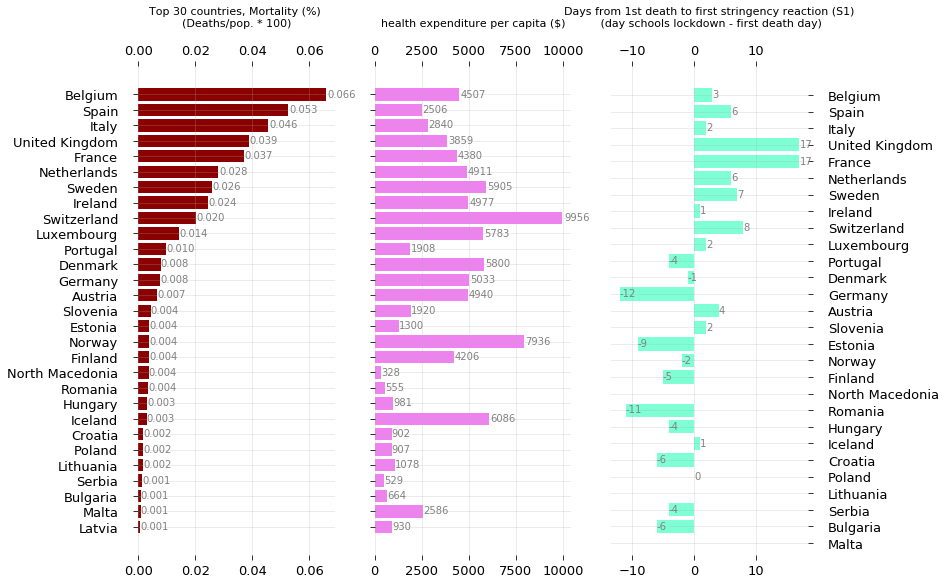

In [93]:
top = 30
f = plt.figure(figsize=(12,9))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

#f.tight_layout(pad=0.05)

padtitle = 40 

#ax1.axes(axisbelow=True)
ax1.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.mortality.values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_title("Top {} countries, Mortality (%) \n(Deaths/pop. * 100)".format(top),fontsize=11, pad=padtitle)
#ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['top'].set_linewidth(0)
ax1.spines['right'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)
for i in ax1.patches:
    ax1.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.3f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax1.xaxis.set_tick_params(labeltop='on',top=True)
ax1.tick_params(axis="y", pad=15)
#plt.savefig(out+'Top 10 Countries (Mortality).png')

#plt.axes(axisbelow=True)
ax2.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.health_capita.values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax2.set_title("Beds per 1000 people",fontsize=11)
ax2.set_title("health expenditure per capita ($)",fontsize=11, pad=padtitle)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
for i in ax2.patches:
    ax2.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax2.xaxis.set_tick_params(labeltop='on',top=True)

#plt.axes(axisbelow=True)
ax3.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.dias_en_actuar_d.values[-top:],color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
ax3.set_title("Days from 1st death to first stringency reaction (S1)\n (day schools lockdown - first death day)",
              fontsize=11, pad=padtitle)
#ax3.set_title("Days until schools lockdown",fontsize=11)
ax3.yaxis.tick_right()
ax3.grid(alpha=0.3,which='both')
ax3.spines['bottom'].set_linewidth(0)
ax3.spines['top'].set_linewidth(0)
ax3.spines['right'].set_linewidth(0)
ax3.spines['left'].set_linewidth(0)
for i in ax3.patches:
    ax3.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')

ax3.xaxis.set_tick_params(labeltop='on',top=True)
ax3.tick_params(axis="y", pad=15)


plt.savefig('mortality and health and reaction.png')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

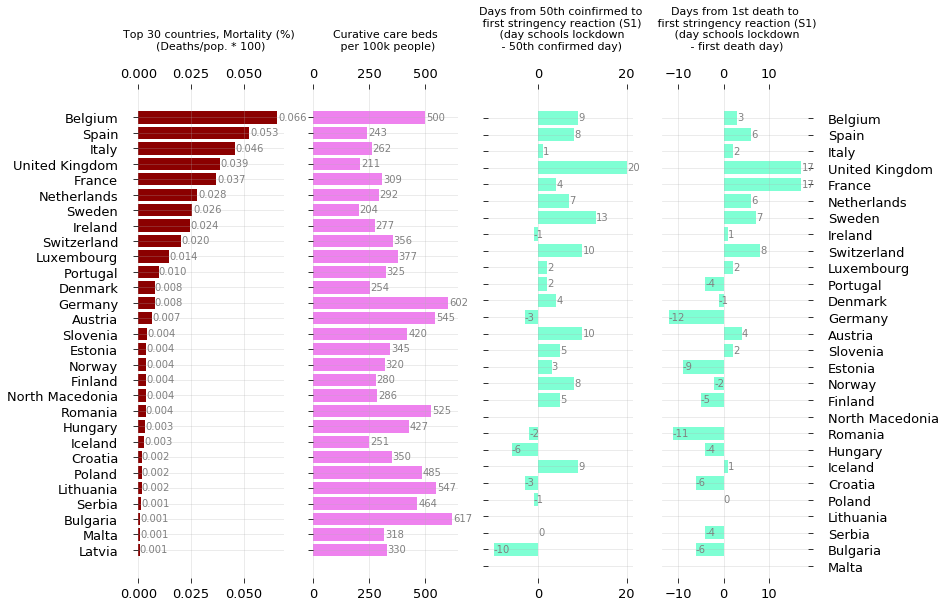

In [94]:
top = 30
f = plt.figure(figsize=(12,9))
ax1 = f.add_subplot(141)
ax2 = f.add_subplot(142)
ax3 = f.add_subplot(143)
ax4 = f.add_subplot(144)

#f.tight_layout(pad=0.05)

padtitle = 40 

#ax1.axes(axisbelow=True)
ax1.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.mortality.values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_title("Top {} countries, Mortality (%) \n(Deaths/pop. * 100)".format(top),fontsize=11, pad=padtitle)
#ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['top'].set_linewidth(0)
ax1.spines['right'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)
for i in ax1.patches:
    ax1.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.3f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax1.xaxis.set_tick_params(labeltop='on',top=True)
ax1.tick_params(axis="y", pad=15)
#plt.savefig(out+'Top 10 Countries (Mortality).png')

#plt.axes(axisbelow=True)
ax2.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.acute_beds.values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax2.set_title("Beds per 1000 people",fontsize=11)
ax2.set_title("Curative care beds\n per 100k people)",fontsize=11, pad=padtitle)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
for i in ax2.patches:
    ax2.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax2.xaxis.set_tick_params(labeltop='on',top=True)

#plt.axes(axisbelow=True)
ax3.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.dias_en_actuar_50c.values[-top:],
         color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax3.set_title("Beds per 1000 people",fontsize=11)
ax3.set_title("Days from 50th coinfirmed to\n first stringency reaction (S1)\n (day schools lockdown\n - 50th confirmed day)"
              ,fontsize=11, pad=padtitle)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax3.set_yticklabels([])
ax3.grid(alpha=0.3,which='both')
ax3.spines['bottom'].set_linewidth(0)
ax3.spines['top'].set_linewidth(0)
ax3.spines['right'].set_linewidth(0)
ax3.spines['left'].set_linewidth(0)
for i in ax3.patches:
    ax3.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax3.xaxis.set_tick_params(labeltop='on',top=True)

#plt.axes(axisbelow=True)
ax4.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.dias_en_actuar_d.values[-top:]
         ,color="aquamarine")
ax4.tick_params(size=5,labelsize = 13)
ax4.set_title("Days from 1st death to\n first stringency reaction (S1)\n (day schools lockdown\n - first death day)",
              fontsize=11, pad=padtitle)
#ax3.set_title("Days until schools lockdown",fontsize=11)
ax4.yaxis.tick_right()
ax4.grid(alpha=0.3,which='both')
ax4.spines['bottom'].set_linewidth(0)
ax4.spines['top'].set_linewidth(0)
ax4.spines['right'].set_linewidth(0)
ax4.spines['left'].set_linewidth(0)
for i in ax4.patches:
    ax4.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')

ax4.xaxis.set_tick_params(labeltop='on',top=True)
ax4.tick_params(axis="y", pad=15)



plt.savefig('mortality and health and reaction.png')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


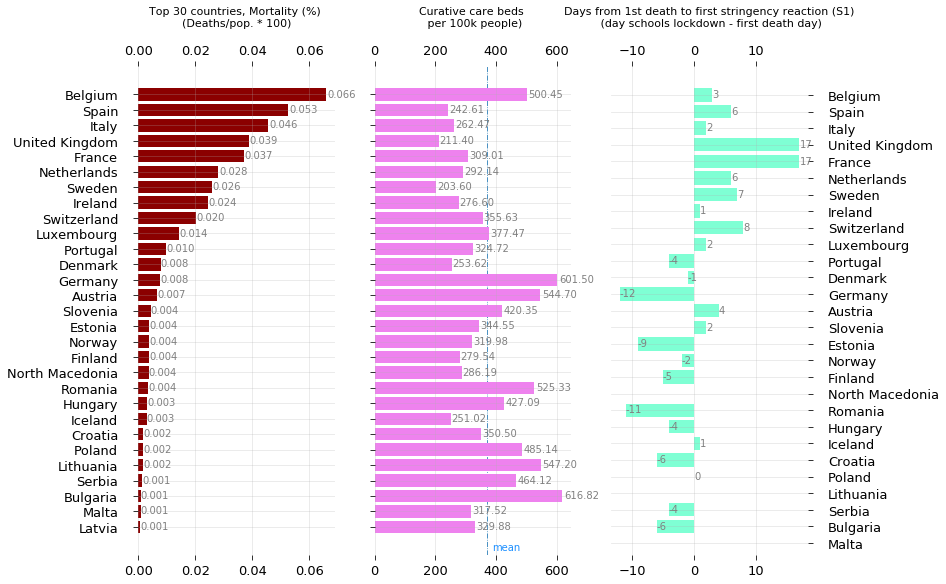

In [95]:
top = 30
f = plt.figure(figsize=(12,9))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

#f.tight_layout(pad=0.05)

padtitle = 40 

#ax1.axes(axisbelow=True)
ax1.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.mortality.values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_title("Top {} countries, Mortality (%) \n(Deaths/pop. * 100)".format(top),fontsize=11, pad=padtitle)
#ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['top'].set_linewidth(0)
ax1.spines['right'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)
for i in ax1.patches:
    ax1.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.3f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax1.xaxis.set_tick_params(labeltop='on',top=True)
ax1.tick_params(axis="y", pad=15)
#plt.savefig(out+'Top 10 Countries (Mortality).png')

#plt.axes(axisbelow=True)
ax2.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.acute_beds.values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax2.set_title("Beds per 1000 people",fontsize=11)
ax2.set_title("Curative care beds \n per 100k people)",fontsize=11, pad=padtitle)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
for i in ax2.patches:
    ax2.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.2f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax2.xaxis.set_tick_params(labeltop='on',top=True)
media = np.array([i.get_width() for i in ax2.patches]).mean()
ax2.axvline(x=media,
            ls='-.', 
            lw=0.8,
            zorder = 0)
ax2.text(media + media*0.05,-1.5,'mean',rotation=0,color='dodgerblue')

#plt.axes(axisbelow=True)
ax3.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.dias_en_actuar_d.values[-top:],color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
ax3.set_title("Days from 1st death to first stringency reaction (S1)\n (day schools lockdown - first death day)",
              fontsize=11, pad=padtitle)
#ax3.set_title("Days until schools lockdown",fontsize=11)
ax3.yaxis.tick_right()
ax3.grid(alpha=0.3,which='both')
ax3.spines['bottom'].set_linewidth(0)
ax3.spines['top'].set_linewidth(0)
ax3.spines['right'].set_linewidth(0)
ax3.spines['left'].set_linewidth(0)
for i in ax3.patches:
    ax3.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')

ax3.xaxis.set_tick_params(labeltop='on',top=True)
ax3.tick_params(axis="y", pad=15)


plt.savefig('mortality and health and reaction.png')

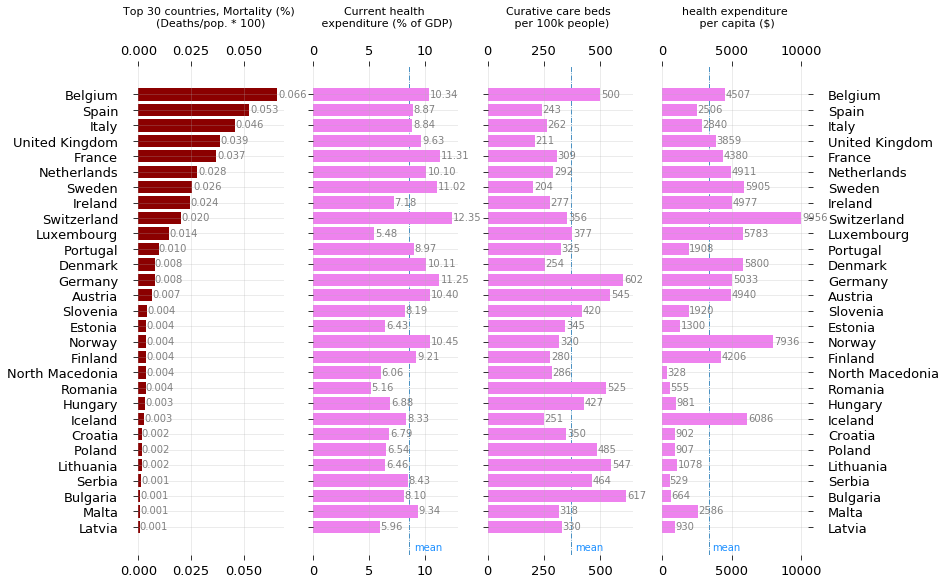

In [96]:
top = 30
f = plt.figure(figsize=(12,9))
ax1 = f.add_subplot(141)
ax2 = f.add_subplot(142)
ax3 = f.add_subplot(143)
ax4 = f.add_subplot(144)

#f.tight_layout(pad=0.05)

padtitle = 40 

#ax1.axes(axisbelow=True)
ax1.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.mortality.values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_title("Top {} countries, Mortality (%) \n(Deaths/pop. * 100)".format(top),fontsize=11, pad=padtitle)
#ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['top'].set_linewidth(0)
ax1.spines['right'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)
for i in ax1.patches:
    ax1.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.3f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax1.xaxis.set_tick_params(labeltop='on',top=True)
ax1.tick_params(axis="y", pad=15)
#plt.savefig(out+'Top 10 Countries (Mortality).png')

#plt.axes(axisbelow=True)
ax2.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.last_hgdp_data.values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax2.set_title("Beds per 1000 people",fontsize=11)
ax2.set_title("Current health \n expenditure (% of GDP)",fontsize=11, pad=padtitle)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
for i in ax2.patches:
    ax2.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.2f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax2.xaxis.set_tick_params(labeltop='on',top=True)
media = np.array([i.get_width() for i in ax2.patches]).mean()
ax2.axvline(x=media,
            ls='-.', 
            lw=0.8,
            zorder = 0)
ax2.text(media + media*0.05,-1.5,'mean',rotation=0,color='dodgerblue')

#plt.axes(axisbelow=True)
ax3.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.acute_beds.values[-top:],color="violet")
ax3.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax2.set_title("Beds per 1000 people",fontsize=11)
ax3.set_title("Curative care beds \n per 100k people)",fontsize=11, pad=padtitle)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax3.set_yticklabels([])
ax3.grid(alpha=0.3,which='both')
ax3.spines['bottom'].set_linewidth(0)
ax3.spines['top'].set_linewidth(0)
ax3.spines['right'].set_linewidth(0)
ax3.spines['left'].set_linewidth(0)
for i in ax3.patches:
    ax3.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax3.xaxis.set_tick_params(labeltop='on',top=True)
media = np.array([i.get_width() for i in ax3.patches]).mean()
ax3.axvline(x=media,
            ls='-.', 
            lw=0.8,
            zorder = 0)
ax3.text(media + media*0.05,-1.5,'mean',rotation=0,color='dodgerblue')


#plt.axes(axisbelow=True)
ax4.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.health_capita.values[-top:],color="violet")
ax4.tick_params(size=5,labelsize = 13)
ax4.set_title("health expenditure\n per capita ($)",fontsize=11, pad=padtitle)
#ax3.set_title("Days until schools lockdown",fontsize=11)
ax4.yaxis.tick_right()
ax4.grid(alpha=0.3,which='both')
ax4.spines['bottom'].set_linewidth(0)
ax4.spines['top'].set_linewidth(0)
ax4.spines['right'].set_linewidth(0)
ax4.spines['left'].set_linewidth(0)
for i in ax4.patches:
    ax4.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')

ax4.xaxis.set_tick_params(labeltop='on',top=True)
ax4.tick_params(axis="y", pad=15)
media = np.array([i.get_width() for i in ax4.patches]).mean()
ax4.axvline(x=media,
            ls='-.', 
            lw=0.8,
            zorder = 0)
ax4.text(media + media*0.05,-1.5,'mean',rotation=0,color='dodgerblue')


plt.savefig('mortality and health and reaction.png')

In [97]:
np.array([i.get_width() for i in ax3.patches]).mean()

369.6948275862069

In [98]:
muertes_europe_cor = compare_muertes_europe[['dias_en_actuar_d',
                                             'dias_en_actuar_50c',
                                             'health_capita',
                                             'PopDensity',
                                             'beds_last_data',
                                             'acute_beds',
                                             'last_hgdp_data',
                                             'mortality']].astype({'beds_last_data':'float64',
                                                                   'last_hgdp_data':'float64'})
muertes_europe_cor.corr().style.background_gradient(cmap='Reds')

In [99]:
compare_muertes_europe

country  acute_beds first_death continent 50first_confirmed  \
17           Latvia      329.88  2020-04-03    Europe        2020-03-18   
19            Malta      317.52  2020-04-08    Europe        2020-03-19   
2          Bulgaria      616.82  2020-03-11    Europe        2020-03-15   
25           Serbia      464.12  2020-03-20    Europe        2020-03-16   
15        Lithuania      547.20  2020-03-21    Europe        2020-03-21   
22           Poland      485.14  2020-03-12    Europe        2020-03-13   
10          Croatia      350.50  2020-03-19    Europe        2020-03-16   
13          Iceland      251.02  2020-03-15    Europe        2020-03-07   
11          Hungary      427.09  2020-03-15    Europe        2020-03-17   
24          Romania      525.33  2020-03-22    Europe        2020-03-13   
18  North Macedonia      286.19  2020-03-22    Europe        2020-03-20   
8           Finland      279.54  2020-03-21    Europe        2020-03-11   
21           Norway      319.98  2020-03-14    Europe        2020-03-04   
6           Estonia      344.55  2020-03-25    Europe        2020-03-13   
27         Slovenia      420.35  2020-03-14    Europe        2020-03-11   
0           Austria      544.70  2020-03-12    Europe        2020-03-06   
4           Germany      601.50  2020-03-09    Europe        2020-02-29   
5           Denmark      253.62  2020-03-14    Europe        2020-03-09   
23         Portugal      324.72  2020-03-17    Europe        2020-03-11   
16       Luxembourg      377.47  2020-03-14    Europe        2020-03-14   
3       Switzerland      355.63  2020-03-05    Europe        2020-03-03   
12          Ireland      276.60  2020-03-11    Europe        2020-03-13   
26           Sweden      203.60  2020-03-11    Europe        2020-03-05   
20      Netherlands      292.14  2020-03-06    Europe        2020-03-05   
9            France      309.01  2020-02-15    Europe        2020-02-28   
28   United Kingdom      211.40  2020-03-06    Europe        2020-03-03   
14            Italy      262.47  2020-02-21    Europe        2020-02-22   
7             Spain      242.61  2020-03-03    Europe        2020-03-01   
1           Belgium      500.45  2020-03-11    Europe        2020-03-05   

   first_measure  dias_en_actuar_d  dias_en_actuar_50c last_hgdp_data  \
17           NaT               NaN                 NaN        5.95566   
19           NaT               NaN                 NaN          9.341   
2     2020-03-05              -6.0               -10.0         8.0956   
25    2020-03-16              -4.0                 0.0        8.43396   
15           NaT               NaN                 NaN        6.45756   
22    2020-03-12               0.0                -1.0        6.54195   
10    2020-03-13              -6.0                -3.0        6.78913   
13    2020-03-16               1.0                 9.0        8.32629   
11    2020-03-11              -4.0                -6.0        6.87999   
24    2020-03-11             -11.0                -2.0        5.15789   
18           NaT               NaN                 NaN        6.06211   
8     2020-03-16              -5.0                 5.0        9.20694   
21    2020-03-12              -2.0                 8.0        10.4463   
6     2020-03-16              -9.0                 3.0        6.42936   
27    2020-03-16               2.0                 5.0        8.18702   
0     2020-03-16               4.0                10.0        10.3966   
4     2020-02-26             -12.0                -3.0        11.2468   
5     2020-03-13              -1.0                 4.0        10.1083   
23    2020-03-13              -4.0                 2.0        8.96957   
16    2020-03-16               2.0                 2.0        5.48107   
3     2020-03-13               8.0                10.0        12.3463   
12    2020-03-12               1.0                -1.0        7.18438   
26    2020-03-18               7.0                13.0        11.0187   
20    202

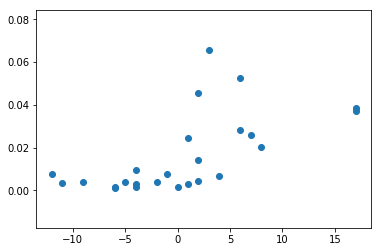

In [100]:
plt.scatter(compare_muertes_europe['dias_en_actuar_d'],compare_muertes_europe['mortality'])

In [101]:
fig = px.scatter(compare_muertes_europe, y=compare_muertes_europe["mortality"],
                    x= compare_muertes_europe["dias_en_actuar_d"],
                    text="country",
                    hover_name="country",
                    hover_data=["acute_beds","Deaths"],
                    range_color= [0, max(np.power(compare_muertes_europe["Deaths"],0.3))], 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Mortalidad COVID-19 vs tiempo de reacción',
                    size_max = 30,
                    height =500
                    )
fig.update_traces(textposition='top center')
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
fig.update_xaxes(title_text="Dias desde el primer fallecido hasta cerrar los colegios")
fig.update_yaxes(title_text="Mortality (%)")
fig.update_layout(
    title="Mortalidad COVID-19 vs tiempo de reacción",
    xaxis_title="Dias desde el primer fallecido hasta cerrar los colegios",
    yaxis_title="mortality (%)",
    font=dict(
        family="Arial",
        size=14,
        color="#7f7f7f"
    )
)
fig.show()

In [102]:
fig = px.scatter(compare_muertes_europe, y=compare_muertes_europe["mortality"],
                    x= compare_muertes_europe["acute_beds"],
                    text="country",
                    hover_name="country",
                    hover_data=["acute_beds","Deaths"],
                    range_color= [0, max(np.power(compare_muertes_europe["Deaths"],0.3))], 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Mortalidad COVID-19 vs camas UCI',
                    size_max = 30,
                    height =500      
                    )
fig.update_traces(textposition='top center',textfont_size=14)
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
fig.update_xaxes(title_text="Número de camas UCI")
fig.update_yaxes(title_text="mortality (%)")
fig.update_layout(
    title="Mortalidad COVID-19 vs camas UCI",
    xaxis_title="Número de camas UCI",
    yaxis_title="mortality (%)",
    font=dict(
        family="Arial",
        size=17,
        color="#7f7f7f"
    )
)
fig.show()

In [103]:
df_deaths.groupby(by=["country","continent"]).sum().reset_index()

country      continent         Lat         Long  1/22/20  \
0               Afghanistan           Asia   33.000000    65.000000        0   
1                   Albania         Europe   41.153300    20.168300        0   
2                   Algeria         Africa   28.033900     1.659600        0   
3                   Andorra         Europe   42.506300     1.521800        0   
4                    Angola         Africa  -11.202700    17.873900        0   
5       Antigua and Barbuda  North America   17.060800   -61.796400        0   
6                 Argentina  South America  -38.416100   -63.616700        0   
7                   Armenia           Asia   40.069100    45.038200        0   
8                 Australia      Australia -255.969500  1129.862300        0   
9                   Austria         Europe   47.516200    14.550100        0   
10               Azerbaijan           Asia   40.143100    47.576900        0   
11                  Bahamas  North America   25.034300   -77.396300        0   
12                  Bahrain           Asia   26.027500    50.550000        0   
13               Bangladesh           Asia   23.685000    90.356300        0   
14                 Barbados  North America   13.193900   -59.543200        0   
15                  Belarus         Europe   53.709800    27.953400        0   
16                  Belgium         Europe   50.833300     4.000000        0   
17                   Belize  North America   13.193900   -59.543200        0   
18                    Benin         Africa    9.307700     2.315800        0   
19                   Bhutan           Asia   27.514200    90.433600        0   
20                  Bolivia  South America  -16.290200   -63.588700        0   
21   Bosnia and Herzegovina         Europe   43.915900    17.679100        0   
22                 Botswana         Africa  -22.328500    24.684900        0   
23                   Brazil  South America  -14.235000   -51.925300        0   
24                   Brunei           Asia    4.535300   114.727700        0   
25                 Bulgaria         Europe   42.733900    25.485800        0   
26             Burkina Faso         Africa   12.238300    -1.561600        0   
27                    Burma         Others   21.916200    95.956000        0   
28                  Burundi         Africa   -3.373100    29.918900        0   
29               Cabo Verde         Africa   16.538800   -23.041800        0   
..                      ...            ...         ...          ...      ...   
155             South Sudan         Africa    6.877000    31.307000        0   
156                   Spain         Europe   40.000000    -4.000000        0   
157               Sri Lanka           Asia    7.000000    81.000000        0   
158                   Sudan         Africa   12.862800    30.217600        0   
159                Suriname  South America    3.919300   -56.027800        0   
160                  Sweden         Europe   63.000000    16.000000        0   
161             Switzerland         Europe   46.818200     8.227500        0   
162                   Syria           Asia   34.802075    38.996815        0   
163                  Taiwan           Asia   23.700000   121.000000        0   
164                Tanzania         Africa   -6.369000    34.888800        0   
165                Thailand           Asia   15.000000   101.000000        0   
166             Timor-Leste         Others   -8.874217   125.727539        0   
167                    Togo         Africa    8.619500     0.824800        0   
168     Trinidad and Tobago  North America   10.691800   -61.222500        0   
169                 Tunisia         Africa   34.000000     9.000000        0   
170                  Turkey           Asia   38.963700    35.243300        0   
171                     USA  North America   37.090200   -95.712900        0   
172                  Uganda         Africa    1.000000    32.000000        0   
173                 

In [104]:
df_deaths

state                 country      continent  \
0                                                 Afghanistan           Asia   
1                                                     Albania         Europe   
2                                                     Algeria         Africa   
3                                                     Andorra         Europe   
4                                                      Angola         Africa   
5                                         Antigua and Barbuda  North America   
6                                                   Argentina  South America   
7                                                     Armenia           Asia   
8        Australian Capital Territory               Australia      Australia   
9                     New South Wales               Australia      Australia   
10                 Northern Territory               Australia      Australia   
11                         Queensland               Australia      Australia   
12                    South Australia               Australia      Australia   
13                           Tasmania               Australia      Australia   
14                           Victoria               Australia      Australia   
15                  Western Australia               Australia      Australia   
16                                                    Austria         Europe   
17                                                 Azerbaijan           Asia   
18                                                    Bahamas  North America   
19                                                    Bahrain           Asia   
20                                                 Bangladesh           Asia   
21                                                   Barbados  North America   
22                                                    Belarus         Europe   
23                                                    Belgium         Europe   
24                                                      Benin         Africa   
25                                                     Bhutan           Asia   
26                                                    Bolivia  South America   
27                                     Bosnia and Herzegovina         Europe   
28                                                     Brazil  South America   
29                                                     Brunei           Asia   
..                                ...                     ...            ...   
234                                                Mozambique         Africa   
235                                                     Syria           Asia   
236                                               Timor-Leste         Others   
237                                                    Belize  North America   
238                         Recovered                  Canada  North America   
239                                                      Laos           Asia   
240                                                     Libya         Africa   
241                                        West Bank and Gaza         Others   
242                                             Guinea-Bissau         Africa   
243                                                      Mali         Africa   
244                                     Saint Kitts and Nevis  North America   
245             Northwest Territories                  Canada  North America   
246                             Yukon                  Canada  North America   
247                                                    Kosovo         Others   
248                                                     Burma         Others   
249                          Anguilla          United Kingdom         Europe   
250            British Virgin Islands          United Kingdom         Europe   
251          Turks and Caicos Islands          United Kingdom         Europe   
252                             

## Plot the evolution

In [105]:
datos_muertes_t = df_deaths.groupby(by=["country","continent"]).sum().reset_index()\
    .melt(id_vars=["country","continent", "Lat", "Long"], 
          var_name="Date", 
          value_name="ac_deaths")
datos_muertes_t['Date'] = datos_muertes_t['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))
datos_muertes_t.sort_values(by='Date', inplace=True)
datos_muertes_t.drop(columns=["Lat","Long"], inplace=True)
datos_muertes_t.head(20)

country      continent       Date  ac_deaths
0              Afghanistan           Asia 2020-01-22          0
118            Netherlands         Europe 2020-01-22          0
119            New Zealand      Australia 2020-01-22          0
120              Nicaragua  North America 2020-01-22          0
121                  Niger         Africa 2020-01-22          0
122                Nigeria         Africa 2020-01-22          0
123        North Macedonia         Europe 2020-01-22          0
124                 Norway         Europe 2020-01-22          0
125                   Oman           Asia 2020-01-22          0
126               Pakistan           Asia 2020-01-22          0
127                 Panama  North America 2020-01-22          0
128       Papua New Guinea      Australia 2020-01-22          0
129               Paraguay  South America 2020-01-22          0
130                   Peru  South America 2020-01-22          0
131            Philippines           Asia 2020-01-22          0
132                 Poland         Europe 2020-01-22          0
133               Portugal         Europe 2020-01-22          0
134                  Qatar           Asia 2020-01-22          0
135  Republic of the Congo         Africa 2020-01-22          0
136                Romania         Europe 2020-01-22          0

In [106]:
muertes_t = datos_muertes_t.merge(population.drop(columns='country'), left_on='country', right_on='country')
muertes_t['deaths100k'] = muertes_t['ac_deaths']/(muertes_t['PopTotal']*1000) * 100000

muertes_t = muertes_t.sort_values(by='Date') # sort rows based on timestamp
muertes_t['timestamp'] = muertes_t.Date.apply(lambda x: x.date()).apply(str) # convert timestamp to a string

muertes_t.head()

country      continent       Date  ac_deaths    PopTotal  \
0              Afghanistan           Asia 2020-01-22          0   38041.757   
11088               Angola         Africa 2020-01-22          0   31825.299   
891               Pakistan           Asia 2020-01-22          0  216565.317   
11187  Antigua and Barbuda  North America 2020-01-22          0      97.115   
11286            Argentina  South America 2020-01-22          0   44780.675   

       PopDensity  deaths100k   timestamp  
0          58.269         0.0  2020-01-22  
11088      25.528         0.0  2020-01-22  
891       280.933         0.0  2020-01-22  
11187     220.716         0.0  2020-01-22  
11286      16.363         0.0  2020-01-22

In [107]:
fig = px.bar(muertes_t[(muertes_t.continent == 'Europe') & (muertes_t.PopTotal > 100) & (muertes_t.Date > "2020-03-01")], 
       x="deaths100k", 
       y="country", 
       text="deaths100k",
       #textposition='auto',
       orientation='h',
       animation_frame="timestamp",
       animation_group="PopTotal",
       color="country",
       template="simple_white",
       range_y=[26.5,37.5],
       range_x=[0,60])\
        .update_yaxes(categoryorder="total ascending")

fig.update_layout(title_text='Europe COVID-19 Mortality per 100k people')
fig.update_traces(texttemplate='%{text:.2f}', textposition='inside')
fig.update_xaxes(title_text="Top 10")
fig.update_yaxes(title_text="Mortality (per 100k)")
fig.update_layout(showlegend=False)
#fig.write_html(out+"mortality_animation.html")

In [112]:
compare_muertes_europe.sort_values(by='deaths100k')['country'].values[-20:]

array(['Romania', 'North Macedonia', 'Finland', 'Norway', 'Estonia',
       'Slovenia', 'Austria', 'Germany', 'Denmark', 'Portugal',
       'Luxembourg', 'Switzerland', 'Ireland', 'Sweden', 'Netherlands',
       'France', 'United Kingdom', 'Italy', 'Spain', 'Belgium'],
      dtype=object)

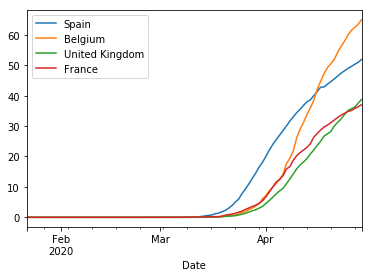

In [113]:
ax = muertes_t[muertes_t['country'] == 'Spain'][['Date','deaths100k']].plot(x='Date',y='deaths100k')
muertes_t[muertes_t['country'] == 'Belgium'][['Date','deaths100k']].plot(x='Date',y='deaths100k', ax=ax)
muertes_t[muertes_t['country'] == 'United Kingdom'][['Date','deaths100k']].plot(x='Date',y='deaths100k', ax=ax)
muertes_t[muertes_t['country'] == 'France'][['Date','deaths100k']].plot(x='Date',y='deaths100k', ax=ax)

ax.legend(["Spain", "Belgium", 'United Kingdom', 'France'])

In [114]:
muertes_t[muertes_t['continent']=='Europe'].to_csv('muertes_t.csv')

In [115]:
pd.read_csv('muertes_t.csv',index_col=[0])

country continent        Date  ac_deaths    PopTotal  \
11583                 Austria    Europe  2020-01-22          0    8955.108   
10989                 Andorra    Europe  2020-01-22          0      77.146   
12177                 Belarus    Europe  2020-01-22          0    9452.409   
12276                 Belgium    Europe  2020-01-22          0   11539.326   
10791  Bosnia and Herzegovina    Europe  2020-01-22          0    3300.998   
10098                 Croatia    Europe  2020-01-22          0    4130.299   
10395                 Czechia    Europe  2020-01-22          0   10689.213   
693                    Norway    Europe  2020-01-22          0    5378.859   
15840                 Estonia    Europe  2020-01-22          0    1325.649   
12870                 Denmark    Europe  2020-01-22          0    5771.877   
12969                 Albania    Europe  2020-01-22          0    2880.913   
594           North Macedonia    Europe  2020-01-22          0    2083.458   
13563                 Hungary    Europe  2020-01-22          0    9684.680   
13662                 Iceland    Europe  2020-01-22          0     339.037   
13959                 Ireland    Europe  2020-01-22          0    4882.498   
14157                   Italy    Europe  2020-01-22          0   60550.092   
1881                  Romania    Europe  2020-01-22          0   19364.558   
5148                  Ukraine    Europe  2020-01-22          0   43993.643   
5346           United Kingdom    Europe  2020-01-22          0   67530.161   
3960               Montenegro    Europe  2020-01-22          0     627.988   
3762                   Monaco    Europe  2020-01-22          0      38.967   
2574            Liechtenstein    Europe  2020-01-22          0      38.020   
2673                Lithuania    Europe  2020-01-22          0    2759.631   
2772               Luxembourg    Europe  2020-01-22          0     615.730   
2079                   Russia    Europe  2020-01-22          0  145872.260   
3366                    Malta    Europe  2020-01-22          0     440.377   
7821                    Spain    Europe  2020-01-22          0   46736.782   
8217                   Sweden    Europe  2020-01-22          0   10036.391   
8514                   Latvia    Europe  2020-01-22          0    1906.740   
8811                 Bulgaria    Europe  2020-01-22          0    7000.117   
...                       ...       ...         ...        ...         ...   
692           North Macedonia    Europe  2020-04-29         73    2083.458   
197               Netherlands    Europe  2020-04-29       4727   17097.123   
1979                  Romania    Europe  2020-04-29        693   19364.558   
3860                   Monaco    Europe  2020-04-29          4      38.967   
3464                    Malta    Europe  2020-04-29          4     440.377   
4058               Montenegro    Europe  2020-04-29          7     627.988   
2870               Luxembourg    Europe  2020-04-29         89     615.730   
2771                Lithuania    Europe  2020-04-29         45    2759.631   
2672            Liechtenstein    Europe  2020-04-29          1      38.020   
2177                   Russia    Europe  2020-04-29        972  145872.260   
8315                   Sweden    Europe  2020-04-29       2462   10036.391   
8414              Switzerland    Europe  2020-04-29       1716    8591.361   
14255                   Italy    Europe  2020-04-29      27682   60550.092   
14057                 Ireland    Europe  2020-04-29       1190    4882.498   
13760                 Iceland    Europe  2020-04-29         10     339.037   
13661                 Hungary    Europe  2020-04-29        300    9684.680   
13067                 Albania    Europe  2020-04-29         30    2880.913   
16829                  Greece    Europe  2020-04-29        139   10473.452   
16631                 Germany    Europe  2020-04-29       6467   83517.046   
12968                 Denmark    Europe  202

## Analisis con respecto a muertes totales en españa

In [116]:
#datos de muertes totales del ministerio
df_momo = pd.read_csv('https://momo.isciii.es/public/momo/data') 

In [117]:
df_momo = df_momo[df_momo.ambito == 'nacional']
df_momo = df_momo.iloc[:,4:]
print(df_momo.shape)
df_momo.head()

(8988, 11)


cod_sexo nombre_sexo cod_gedad nombre_gedad fecha_defuncion  \
0      all       todos       all        todos      2018-04-12   
1      all       todos       all        todos      2018-04-13   
2      all       todos       all        todos      2018-04-14   
3      all       todos       all        todos      2018-04-15   
4      all       todos       all        todos      2018-04-16   

   defunciones_observadas  defunciones_observadas_lim_inf  \
0                    1196                          1196.0   
1                    1149                          1149.0   
2                    1120                          1120.0   
3                    1073                          1073.0   
4                    1047                          1047.0   

   defunciones_observadas_lim_sup  defunciones_esperadas  \
0                          1196.0                1088.75   
1                          1149.0                1083.50   
2                          1120.0                1082.25   
3                          1073.0                1081.25   
4                          1047.0                1076.00   

   defunciones_esperadas_q01  defunciones_esperadas_q99  
0                    1006.59                   1168.100  
1                    1001.07                   1159.135  
2                     980.08                   1159.135  
3                     980.08                   1155.810  
4                     980.08                   1159.910

In [118]:
df_momo['fecha_defuncion'] = df_momo['fecha_defuncion'].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d"))

In [122]:
#Todos los datos de muertes sin sexo ni edad
df_momo_todos = df_momo[(df_momo.nombre_sexo == 'todos') & (df_momo.nombre_gedad == 'todos')]

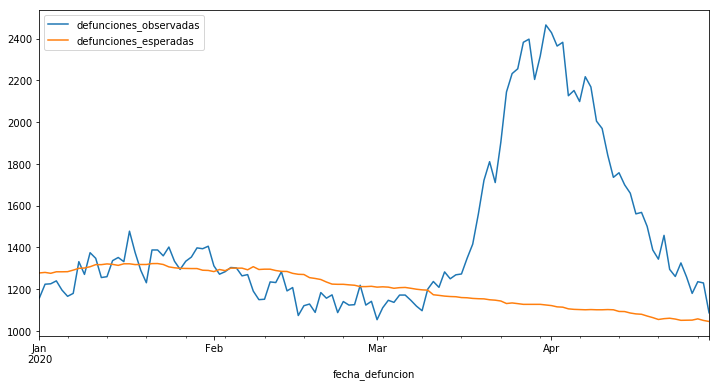

In [123]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
df_momo_todos[(df_momo_todos.fecha_defuncion.dt.year == 2020)].plot(kind='line',
                                                      x='fecha_defuncion',
                                                      y='defunciones_observadas',
                                                      ax=ax
                                                    )
df_momo_todos[(df_momo_todos.fecha_defuncion.dt.year == 2020)].plot(kind='line',
                                                      x='fecha_defuncion',
                                                      y='defunciones_esperadas',
                                                      ax=ax
                                                    )

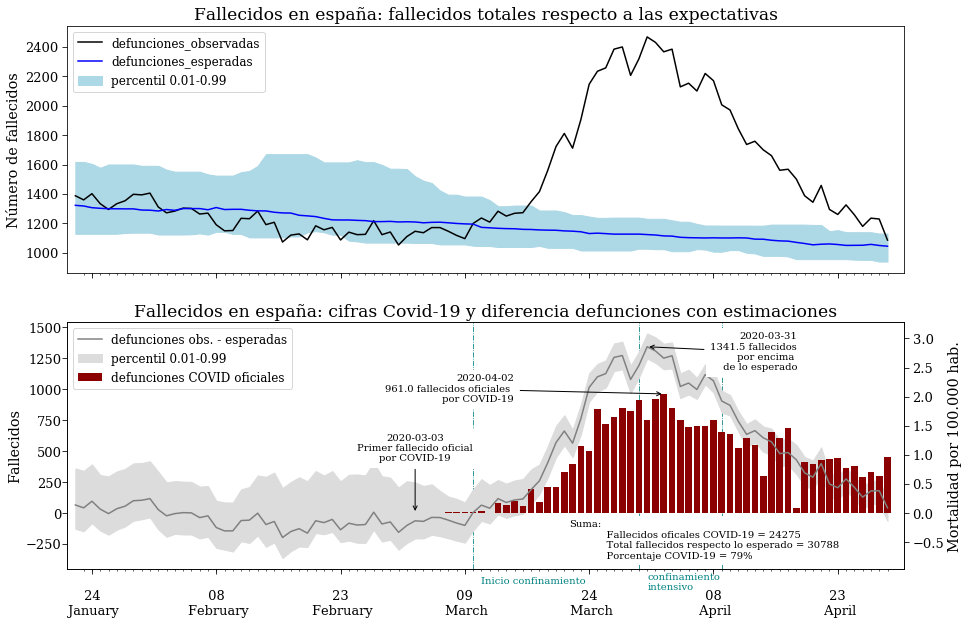

In [153]:
muertes_covid_spain = df_deaths[df_deaths.country == 'Spain'].iloc[:,5:].T.reset_index() \
                    .rename(columns={'index':'Date', 201:'accum'})
muertes_covid_spain['Date'] = pd.to_datetime(muertes_covid_spain['Date'], format='%m/%d/%y')

muertes_covid_spain['deaths_covid'] = muertes_covid_spain.accum.diff()
muertes_covid_spain = muertes_covid_spain.set_index('Date', drop=True)

df_momo_todos = df_momo[(df_momo.nombre_sexo == 'todos') & (df_momo.nombre_gedad == 'todos')] \
                    .rename(columns={'fecha_defuncion':'Date'}) \
                    .set_index('Date', drop=True)


df = df_momo_todos.merge(muertes_covid_spain,left_index=True, right_index=True)
df = df.reset_index()
df['dif_esperados'] = df['defunciones_observadas'] - df['defunciones_esperadas']

df['q99'] = df['defunciones_esperadas_q99'] - df['defunciones_esperadas']
df['q01'] = df['defunciones_esperadas'] - df['defunciones_esperadas_q01']

df['m99'] = df['defunciones_observadas'] + df['q99']
df['m01'] = df['defunciones_observadas'] - df['q01']

df['e99'] = df['dif_esperados'] + df['q99']
df['e01'] = df['dif_esperados'] - df['q01']

import os
from matplotlib import font_manager as fm, rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = 'EB Garamond'


fpath = os.path.join(rcParams["datapath"], "EB_Garamond/static/EBGaramond-Medium.ttf")
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax)


df[(df.Date.dt.year == 2020)].loc[:,'defunciones_observadas'].plot(kind='line',
                                                                   ax=ax,
                                                                   color='black',
                                                                  ).set_label('defunciones')
df[(df.Date.dt.year == 2020)].loc[:,'defunciones_esperadas'].plot(kind='line',
                                                                  ax=ax,
                                                                  color='blue'
                                                                 ).set_label('defunciones esperadas')

ax.fill_between(df[(df.Date.dt.year == 2020)].index,
                df[(df.Date.dt.year == 2020)].loc[:,'defunciones_esperadas_q01'],
                df[(df.Date.dt.year == 2020)].loc[:,'defunciones_esperadas_q99'],
                color='lightblue'
               ).set_label('percentil 0.01-0.99')

hfont = {'fontname':'EB Garamond'}
ax.legend(loc="upper left",
          fontsize='large'
          )



df[(df.Date.dt.year == 2020)].loc[:,'deaths_covid'].plot(kind='bar',
                                                         ax=ax2,
                                                         width=0.8,
                                                         color='darkred'
                                                    ).set_label('defunciones COVID oficiales')

df[(df.Date.dt.year == 2020)].loc[:,'dif_esperados'].plot(kind='line',
                                                          ax=ax2,
                                                          color='gray'
                                                    ).set_label('fallecidos - esperados')

ax2.fill_between(df[(df.Date.dt.year == 2020)].index,
                df[(df.Date.dt.year == 2020)].loc[:,'e01'],
                df[(df.Date.dt.year == 2020)].loc[:,'e99'],
                color='gainsboro',
               )
#df[(df.Date.dt.year == 2020)].loc[:,['e01','e99']].plot(kind='line',
#                                                      ax=ax2
#                                                    )
ax2.legend(['defunciones obs. - esperadas','percentil 0.01-0.99','defunciones COVID oficiales'],
           loc="upper left",
           fontsize='large'
          )

#xticks Indices fechas

l = len(df[(df.Date.dt.year == 2020)])
ind = np.arange(2,l,15).tolist()

ax2.set_xticklabels(df[(df.Date.dt.year == 2020)].Date[ind].dt.strftime('\n %d \n %B'), 
                    rotation=0
                   )
#ax.set_xticks(df.Date[ind].dt.strftime('%d, %B'))

ax.set_xticks(ind)

xticks_minor = np.arange(1,l,1).tolist()
ax2.set_xticks(xticks_minor, minor=True )
ax2.set_xlim(-1, l+1)
ax2.tick_params(pad=0.5)

#lineas verticales confinamientos
fecha_inicio_confinamiento = datetime(2020,3,10)
fecha_endurecimiento_confinamiento = datetime(2020,3,30)
fecha_finendurecimiento_confinamiento = datetime(2020,4,9)

color_lineas = 'teal'
yyy = -620
indice_inicio_confinamiento = df[(df.Date.dt.year == 2020)].loc[df.Date == fecha_inicio_confinamiento].index.values[0]
ax2.axvline(x=indice_inicio_confinamiento,
            ls='-.', 
            lw=0.8,
            zorder = 0,
            color=color_lineas)
ax2.text(indice_inicio_confinamiento+1,yyy+50,
         "Inicio confinamiento",
         rotation=0,
         color=color_lineas)


indice_inicio_confinamiento = df[(df.Date.dt.year == 2020)].loc[df.Date == fecha_endurecimiento_confinamiento].index.values[0]
ax2.axvline(x=indice_inicio_confinamiento,
            ls='-.', 
            lw=0.8,
            zorder = 0,
            color=color_lineas)
ax2.text(indice_inicio_confinamiento+1,yyy,
         "confinamiento\nintensivo",
         rotation=0,
         color=color_lineas)

indice_inicio_confinamiento = df[(df.Date.dt.year == 2020)].loc[df.Date == fecha_finendurecimiento_confinamiento].index.values[0]
ax2.axvline(x=indice_inicio_confinamiento,
            ls='-.', 
            lw=0.8,
            zorder = 0,
            color=color_lineas)





ax.set_title('Fallecidos en españa: fallecidos totales respecto a las expectativas', fontsize='xx-large')
ax2.set_title('Fallecidos en españa: cifras Covid-19 y diferencia defunciones con estimaciones', fontsize='xx-large')
ax.set_ylabel('Número de fallecidos',fontsize='x-large')
ax2.set_ylabel('Fallecidos',fontsize='x-large')
ax.tick_params(size=5,labelsize = 13)
ax2.tick_params(size=5,labelsize = 13)

#w = df[(df.Date.dt.year == 2020)].Date.dt.weekday.tolist()
#weekDays = ("L","M","X","J","V","S","D")
#ww = list(map(lambda x: weekDays[x], w))

ax_c = ax2.twinx()

y1, y2 = ax2.get_ylim()
ax_c.set_ylim(y1/46940000*100000, y2/46940000*100000)
ax_c.figure.canvas.draw()
ax_c.set_ylabel('Mortalidad por 100.000 hab.',fontsize='x-large')
ax_c.tick_params(size=5,labelsize = 13)

maximo1i=df[(df.Date.dt.year == 2020)]['dif_esperados'].idxmax()
maximo1=df[(df.Date.dt.year == 2020)]['dif_esperados'].max()

maximo2i=df[(df.Date.dt.year == 2020)]['deaths_covid'].idxmax()
maximo2=df[(df.Date.dt.year == 2020)]['deaths_covid'].max()

ax2.annotate("{}\n{} fallecidos\n por encima \n de lo esperado".format(df.Date.dt.date.iloc[maximo1i],maximo1), 
             (maximo1i,maximo1), 
             xytext=(150, 15), 
             xycoords='data', 
             arrowprops=dict(arrowstyle='->'),
             textcoords='offset points',
             backgroundcolor="w",
             horizontalalignment='right', verticalalignment='top')

ax2.annotate("{}\n{} fallecidos oficiales \n por COVID-19".format(df.Date.dt.date.iloc[maximo2i],maximo2), 
             (maximo2i,maximo2), 
             xytext=(-150, 20), 
             xycoords='data', 
             arrowprops=dict(arrowstyle='->'),
             textcoords='offset points',
             backgroundcolor="w",
             horizontalalignment='right', verticalalignment='top')


muertos_totales_covid = df[(df.Date.dt.year == 2020)]['deaths_covid'].sum()
diferencia_total = df[(df.Date.dt.year == 2020) & (df.deaths_covid>0)]['dif_esperados'].sum()
error = muertos_totales_covid/diferencia_total*100

ax2.annotate("""Suma:
            Fallecidos oficales COVID-19 = {:.0f}
            Total fallecidos respecto lo esperado = {:.0f}
            Porcentaje COVID-19 = {:.0f}%""".format(muertos_totales_covid,
                                                    diferencia_total,
                                                    error
                                                   ), 
             (0.6,0.2), 
             xytext=(0, 0), 
             xycoords='axes fraction', 
             textcoords='offset points',
             backgroundcolor="w",
             horizontalalignment='left', verticalalignment='top')


primer_muerto = df[(df.Date.dt.year == 2020) & (df.deaths_covid>0)].Date.iloc[0]
pos1 = df[(df.Date == primer_muerto)].index.values[0]

ax2.annotate("{}\nPrimer fallecido oficial\npor COVID-19".format(primer_muerto.strftime("%Y-%m-%d"),
                                                                ), 
             (pos1,0), 
             xytext=(0, 80), 
             xycoords='data', 
             arrowprops=dict(arrowstyle='->'),
             textcoords='offset points',
             backgroundcolor="w",
             horizontalalignment='center', verticalalignment='top')

#ax2.annotate('Something', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig(out+'comparacion_fallecidos_totales.png')


In [131]:
fecha_inicio_confinamiento

datetime.datetime(2020, 3, 9, 0, 0)

In [134]:
df[(df.Date.dt.year == 2020)].loc[df.Date == fecha_inicio_confinamiento]

Date cod_sexo nombre_sexo cod_gedad nombre_gedad  \
47 2020-03-09      all       todos       all        todos   

    defunciones_observadas  defunciones_observadas_lim_inf  \
47                    1097                          1097.0   

    defunciones_observadas_lim_sup  defunciones_esperadas  \
47                          1097.0                 1197.0   

    defunciones_esperadas_q01  defunciones_esperadas_q99  accum  deaths_covid  \
47                    1057.73                    1382.77     28          11.0   

    dif_esperados     q99     q01      m99     m01    e99     e01  
47         -100.0  185.77  139.27  1282.77  957.73  85.77 -239.27